<a href="https://colab.research.google.com/github/SultanShadow/cac22_nb_resources/blob/main/PLL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **_Clock Multiplier (PLL) on Global Foundry 180nm PDK_**<br/>
**_submission under category-2_**

```
Shahid Jamil, November 2022
SPDX-License-Identifier: Apache-2.0
```

|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
|Rana M Shahid Jamil <br /> Email ID: i201304@nu.edu.pk |National University of Computer and Emerging Sciences|Yes|Yes|

**_Index Terms:_** CPLL, Clock Multiliplier, open source, GF180MCU.

## **Introduction,Background and Motivation**

Back in 2020, Skywater foundaries and Google collaborated to give the world the first ever open-source Process Design Kit (PDK). It was a hybrid 130nm CMOS technology. Since them google has sponsored MPW-runs to enable the open-source IC design community to tapeout their projects using open-source EDA tools. Quite recently, global foundries also made their 180nm CMOS PDK open-source. This project is aimed to explore the GF180MCU PDK from the analog and mixed signal perspective.

A PLL (Phase-Locked-Loop) is a feedback control system that compares the phase of its output 
signal with a reference input signal and attempts to reduce any mismatches/error in the phases of 
the two signals. Once in a locked state, the output signal tracks the input signal. If the reference 
signal has low jitter/phase noise and high precision, the output signal will also have these
characteristics. Almost all analog, digital and mixed signal electronic circuits; require precise and 
stable timing signals in the form of Clocks, Local Oscillators(LOs) etc. On chip Oscillators do 
not have these characteristics. Therefore, PLLs are used to lock on-chip oscillators with external 
off-chip reference oscillators. 


In modern world’s analog and digital electronics, high speed operation is required; for example,
a desktop microprocessor may be operating at a Clock frequency of 3 GHz or an RF front end of 
a communication module may require a local oscillator of 5GHz. Both of these circuits will 
require on chip oscillators at the desired frequencies. There are a number of problems however
with on-chip oscillators. They do not have a very high Q (quality factor) and as such they have 
poor stability, high jitter/phase noise. Secondly, it is difficult to know the exact frequency of 
oscillation of on-chip oscillators. Off-chip oscillators, on the other hand, can make use of High Q 
resonators to generate very precise, stable and low noise timing references. But to make these 
cost-effective, the frequencies of these signals are often limited to the range of about few KHz to 
200MHz. High Q oscillators with even higher output frequencies become costly and in many 
cases the bandwidth is limited by the chip-pads, package/bond wire parasitics etc. which does not 
allow the Input/output of high frequency signals from the chips with reasonable integrity

This notebook submission describes a basic Charge Pump PLL design that generates an on-chip 
clock of 128MHz by locking on to an external reference clock at 2MHz. The circuit has an 
internal tuning voltage range from 0.8V to 3.3 Volts which corresponds to frequency tuning of 
VCOs output from 40-170MHz. The circuit has lock acquisition time of about 50us. The output of 
this digital PLL can be used to operate on-chip digital circuitry at a clock rate of 128MHz. The 
design has been implemented on the Global Foundary 180nm open source CMOS pdk, using open 
source EDA tools.

### **Phase Locked Loop**

The most widely used solution to generate high frequency timing reference signals on chip is by 
designing Phase Locked Loops. A phase locked loop works in a feedback manner. An on chip 
Voltage Controlled Oscillator (VCO) generates a timing signal. The output frequency of this 
signal is divided by a factor N. This divided signal and reference signal are compared by a Phase 
Detector (PD) circuit. The PD generates an output if the two input signals are not locked. This 
output generates a control voltage for the VCO. This control voltage attempts to bring the 
oscillation frequency of the VCO to NxFin. This goes on until the two input signals of the PD are 
locked with each other. A basic PLL architecture is shown in the Figure below.

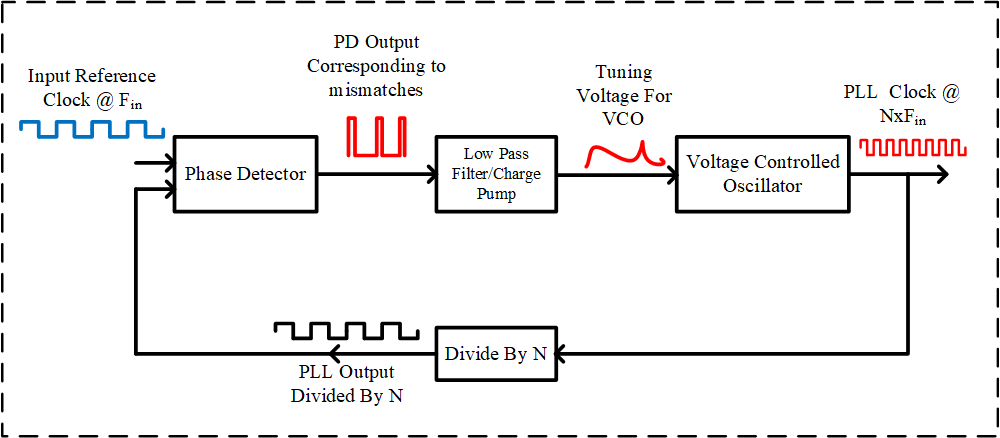

In [1]:
import IPython.display
from IPython.display import Image
Image("./images/PLL_Block.png")

-------------------------------------------------------------------------------

### **Design Flow**

The design flow is organized as follows:

*   Environment Setup.
*   Gates Simulation.
   *   INV/NAND/ D-Flip FLop.
*   Ring Oscillator.
*   Voltage Controlled Oscillator.
*   Phase Detector Circuit.
*   Frequency Divider.
*   Complete PLL Schematic.



**Environment Setup**

In [ ]:
# Install PDK and Ngspice
# Reference: https://github.com/idea-fasoc/OpenFASOC/blob/main/docs/source/notebooks/temp_sense_genCollab.ipynb
import os, sys, pathlib
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned


!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        --channel conda-forge \
                        ngspice \
                        gdstk cairosvg pip 
#!bin/micromamba install --yes --prefix $CONDA_PREFIX \
#                        --channel conda-forge \
#                        ngspice

#Copy magicrc file for sky130A to current Directory 
#!cp ./conda-env/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc .magicrc

# Other packages for post-processing
import pandas as pd
import matplotlib.pyplot as plt

**Inverter Simulation**

The minimum voltage device available in the GF180nm open-source PDK is of 3.3V. Unfortunately, the standard cells operate at 5V. Inorder to conserve power, it was decided to to use 3.3V devices. Since the standard cells are not available at this voltage, we had to design our own basic gates, the first of which is an inverter. The minimum length allowed for the transistors is 0.28um. Choosing W/L ~= 3 we simulate a simple inverter in xschem as shown in figure.

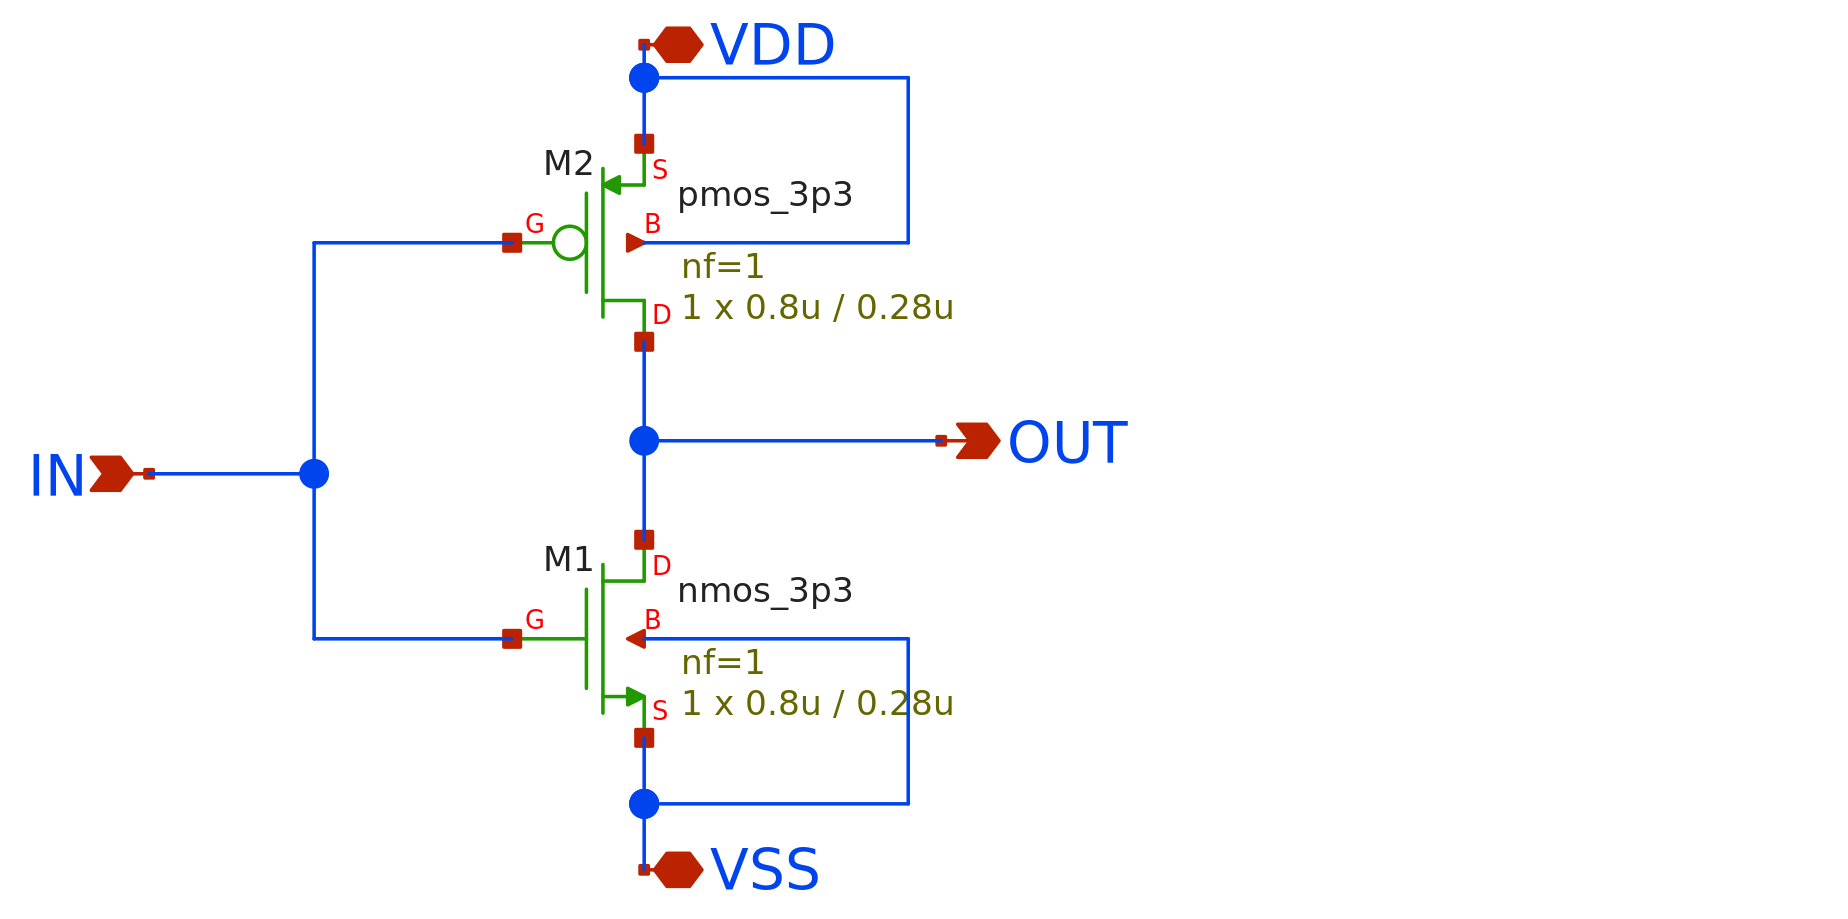

In [3]:
Image('./images/inv.png')

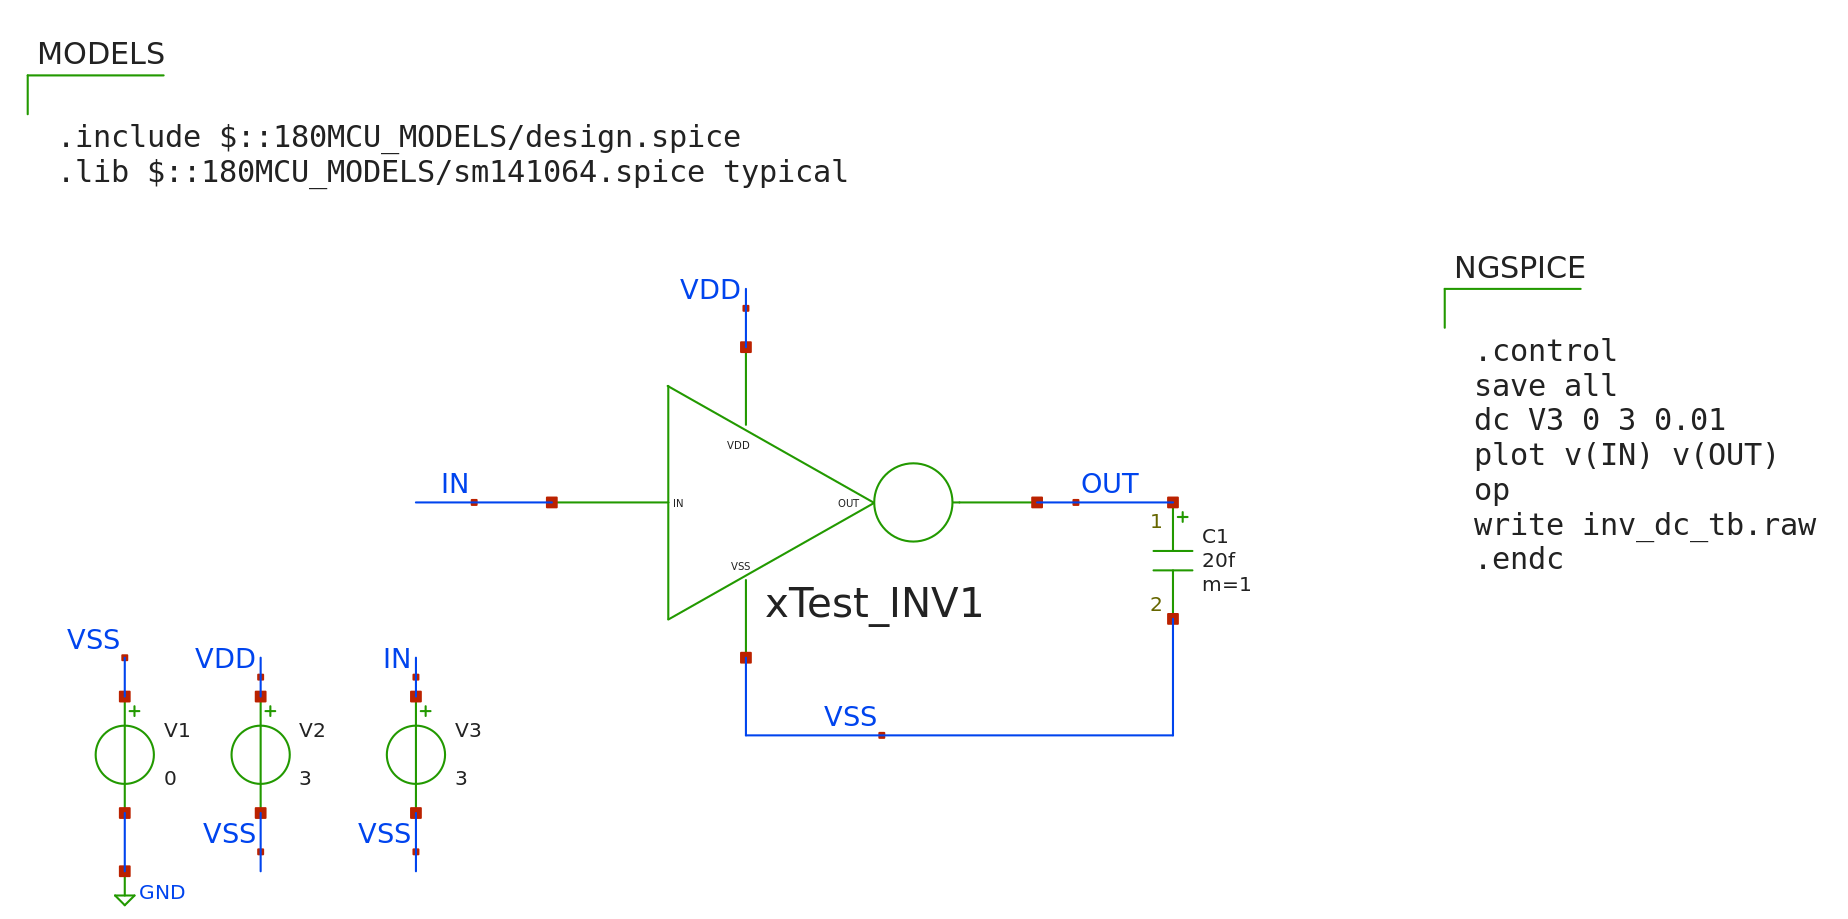

In [4]:
Image('./images/inv_dc.png')

Writing Netlist as generated from the xschem

In [5]:
%%writefile inv.spice
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/inv_dc_tb.sch
**.subckt inv_dc_tb
C1 OUT VSS 20f m=1
V1 VSS GND 0
.save i(v1)
V2 VDD VSS 3
.save i(v2)
V3 IN VSS 3
.save i(v3)
xTest_INV1 VDD VSS IN OUT Test_INV
**** begin user architecture code

.include ./ngspice/design.spice
.lib ./ngspice/sm141064.spice typical



.control
save all
dc V3 0 3 0.01
*plot v(IN) v(OUT)
WRDATA inv_dc_1.csv v(IN) v(OUT)
.endc


**** end user architecture code
**.ends

* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/Test_INV.sym # of pins=4
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/Test_INV.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/Test_INV.sch
.subckt Test_INV VDD VSS IN OUT
*.ipin IN
*.iopin VDD
*.iopin VSS
*.opin OUT
XM1 OUT IN VSS VSS nmos_3p3 L=0.28u W=0.8u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM2 OUT IN VDD VDD pmos_3p3 L=0.28u W=0.8u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
.ends

.GLOBAL GND
.end


Writing inv.spice


Simulate and Plot the DC Charateristics of the Inverter

In [6]:
%%writefile .spiceinit
* ngspice initialization for sky130
* assert BSIM compatibility mode with "nf" vs. "W"
*set ngbehavior=hsa
* "nomodcheck" speeds up loading time
set ng_nomodcheck
set num_threads=2

Writing .spiceinit


In [7]:
!ngspice -b inv.spice

ngspice: /content/conda-env/bin/../lib/libtinfo.so.6: no version information available (required by ngspice)

Note: No compatibility mode selected!


Circuit: ** sch_path: /home/shahidosic/gfprojects/pll/xschem/inv_dc_tb.sch

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 301
Note: No ".plot", ".print", or ".fourier" lines; no simulations run


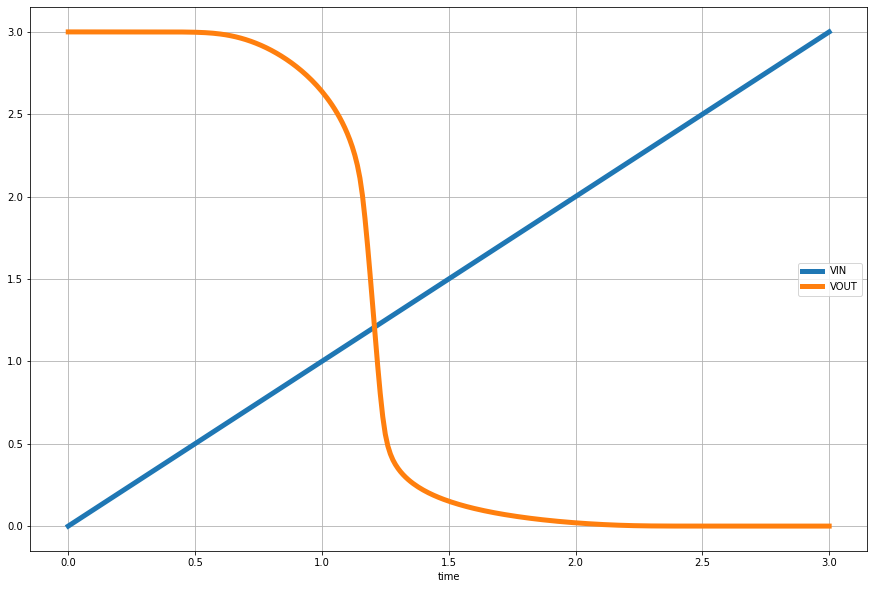

In [8]:
df = pd.read_csv("./inv_dc_1.csv", delim_whitespace=True, header=None)
df.columns = ["time", "VIN","time2", "VOUT"]
#df
df.plot(x="time", y=["VIN","VOUT"], grid=True, figsize=(15,10), linewidth=5)
plt.show()

As can be osbserved from the above figure that the inverter is not symmetric. The NMOS is stronger than PMOS and as such rise and fall times are not going to be equal. To make the inverter symmetric, the width of PMOS is changed to 2.4um (3 times the width of NMOS). The new netlist is simulated again

In [9]:
%%writefile inv_symm.spice
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/inv_dc_tb.sch
**.subckt inv_dc_tb
C1 OUT VSS 20f m=1
V1 VSS GND 0
.save i(v1)
V2 VDD VSS 3
.save i(v2)
V3 IN VSS 3
.save i(v3)
xTest_INV1 VDD VSS IN OUT Test_INV
**** begin user architecture code

.include ./ngspice/design.spice
.lib ./ngspice/sm141064.spice typical



.control
save all
dc V3 0 3 0.01
*plot v(IN) v(OUT)
WRDATA inv_dc_2.csv v(IN) v(OUT)
.endc


**** end user architecture code
**.ends

* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/Test_INV.sym # of pins=4
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/Test_INV.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/Test_INV.sch
.subckt Test_INV VDD VSS IN OUT
*.ipin IN
*.iopin VDD
*.iopin VSS
*.opin OUT
XM1 OUT IN VSS VSS nmos_3p3 L=0.28u W=0.8u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM2 OUT IN VDD VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
.ends

.GLOBAL GND
.end


Writing inv_symm.spice


In [10]:
!ngspice -b inv_symm.spice

ngspice: /content/conda-env/bin/../lib/libtinfo.so.6: no version information available (required by ngspice)

Note: No compatibility mode selected!


Circuit: ** sch_path: /home/shahidosic/gfprojects/pll/xschem/inv_dc_tb.sch

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


No. of Data Rows : 301
Note: No ".plot", ".print", or ".fourier" lines; no simulations run


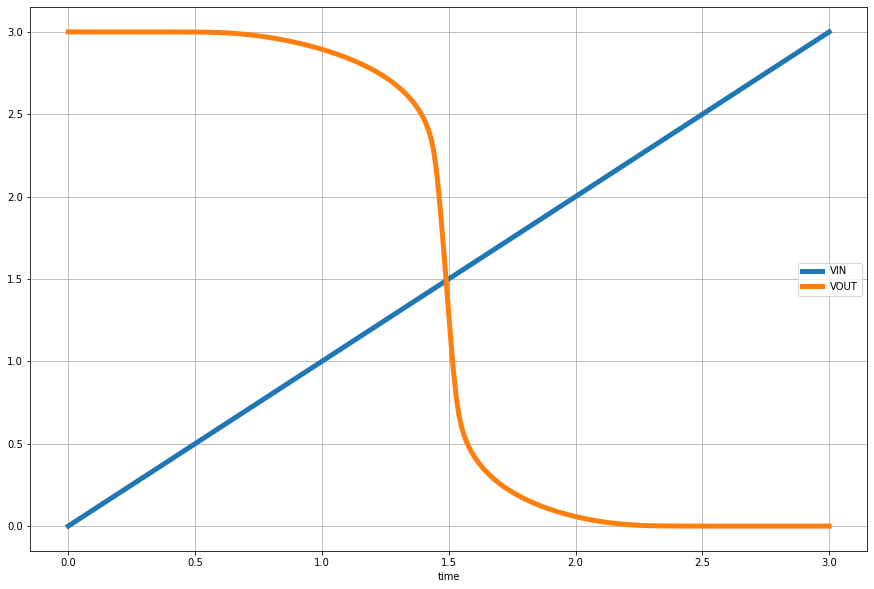

In [11]:
df = pd.read_csv("./inv_dc_2.csv", delim_whitespace=True, header=None)
df.columns = ["time", "VIN","time2", "VOUT"]
#df
df.plot(x="time", y=["VIN","VOUT"], grid=True, figsize=(15,10), linewidth=5)
plt.show()

As can be osbserved from the previous figure that the inverter is symmetric now and will have equal rise and fall times. We also learn that the NMOS is 3 times stronger than PMOS for same width and length. Using the same principle, 2 and 3 input NAND gates and a D-Flip Flop is designed. The xschem schematics are shown in the following figures.

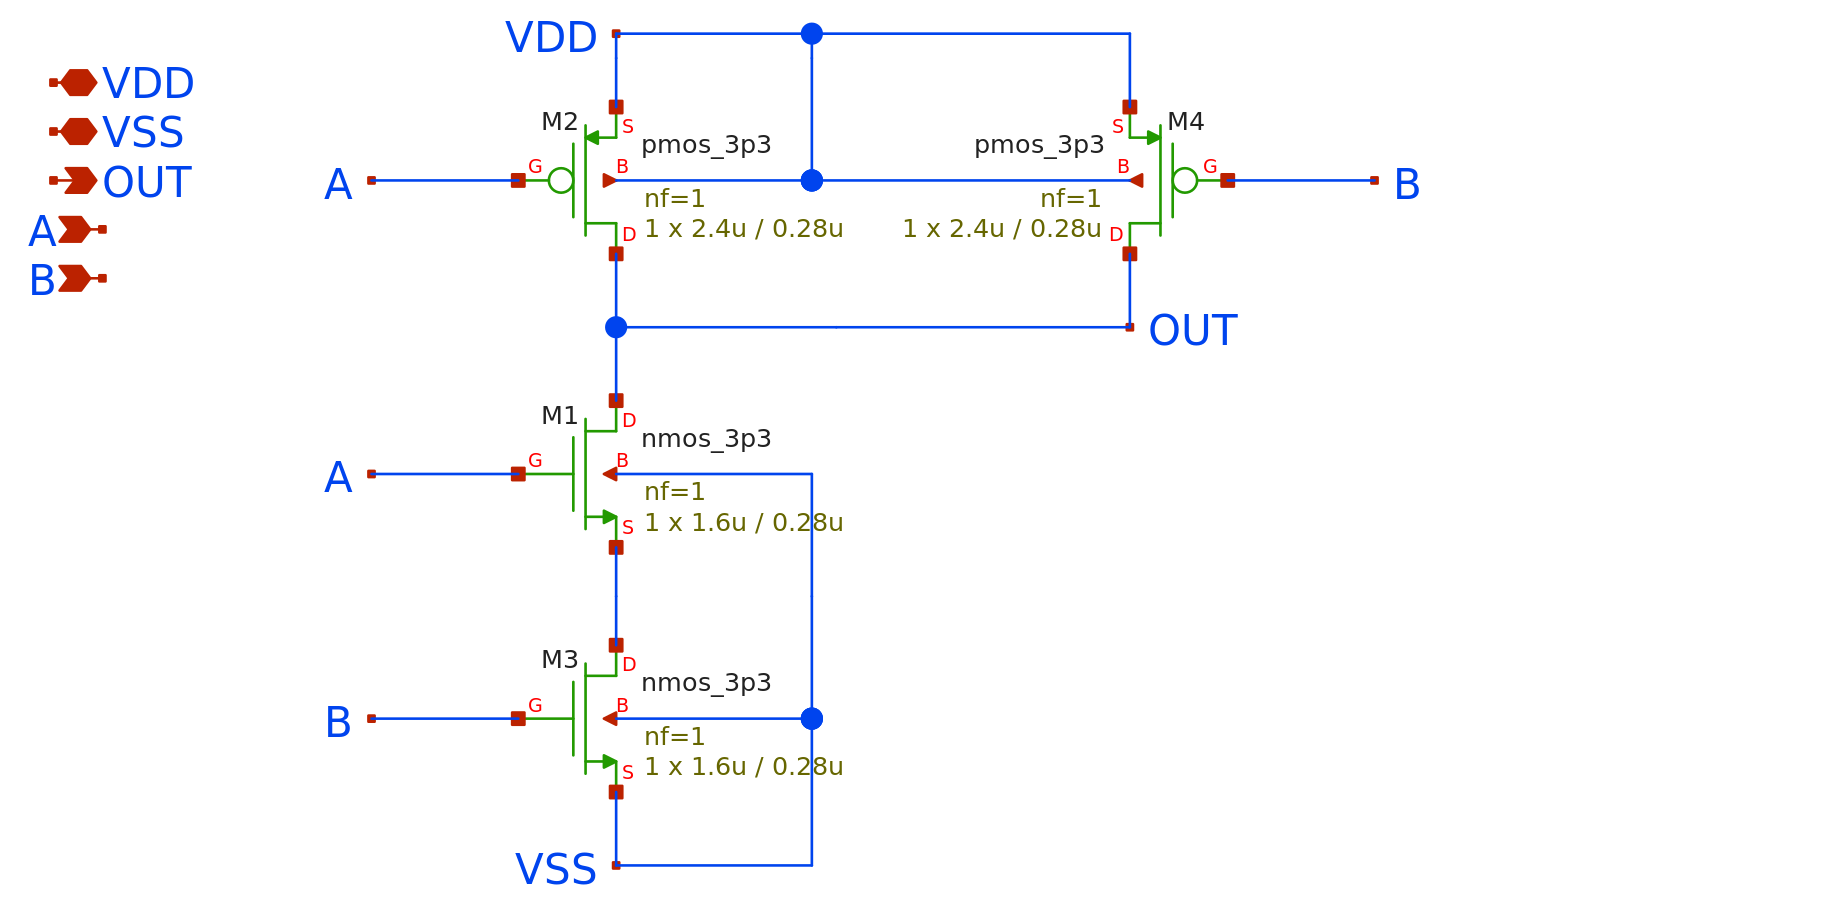

In [12]:
Image('./images/NAND.png')

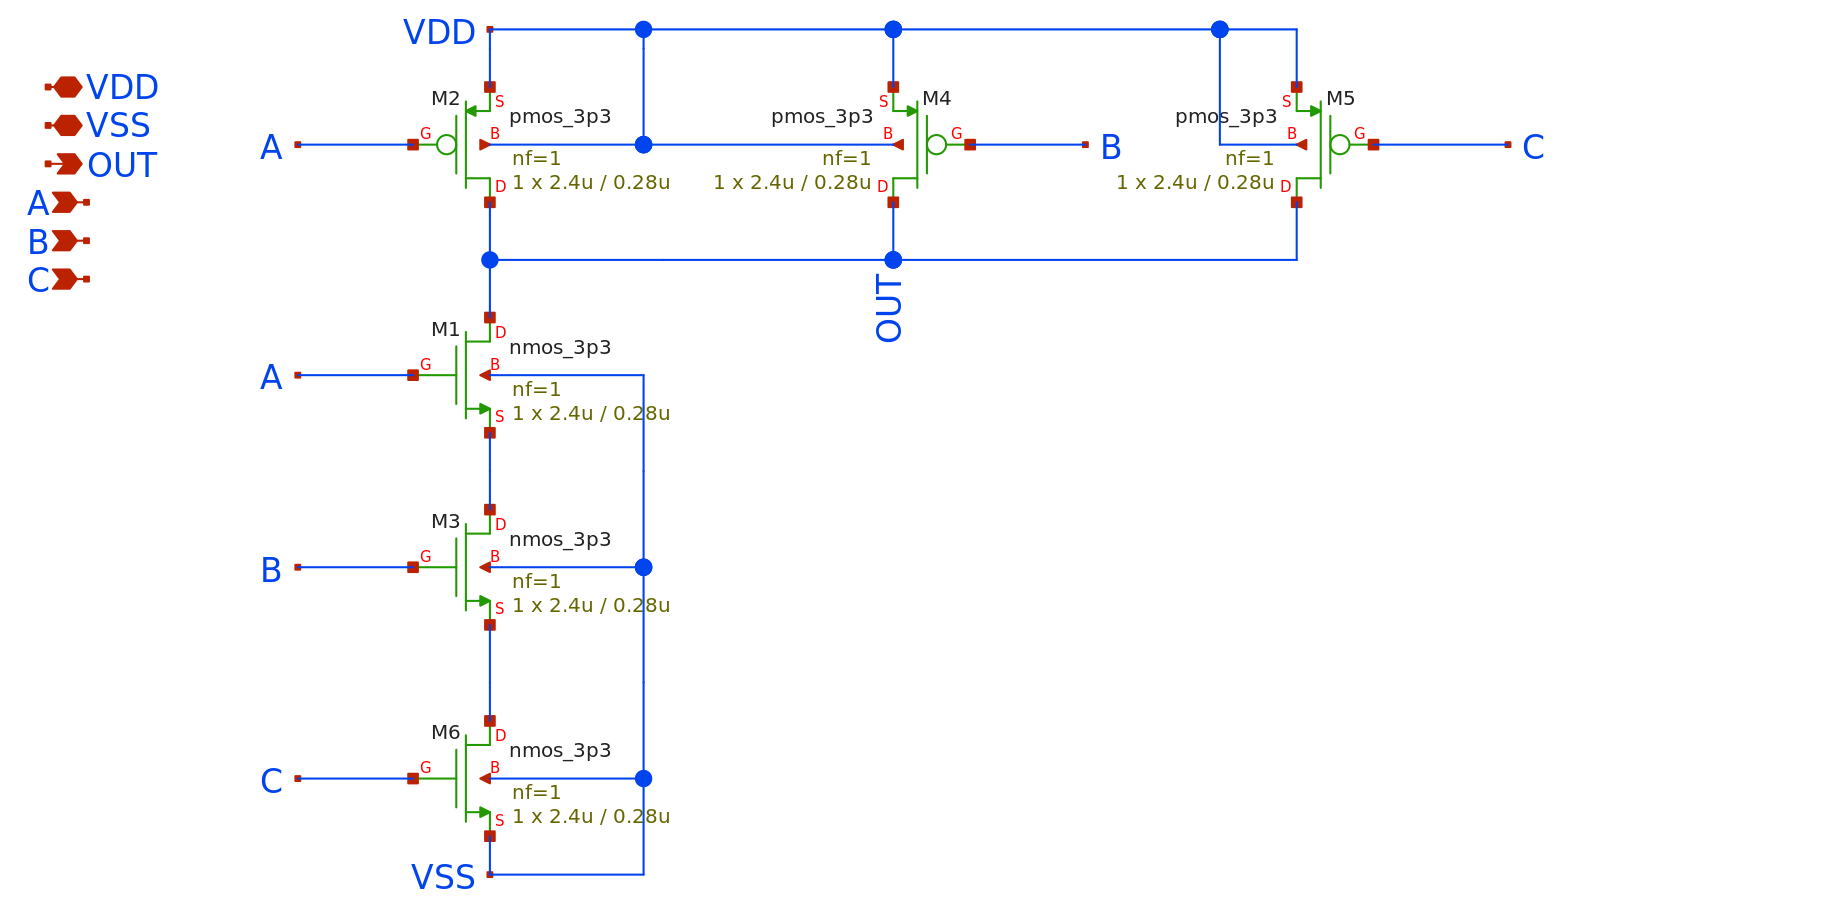

In [13]:
Image('./images/NAND_TI.png')

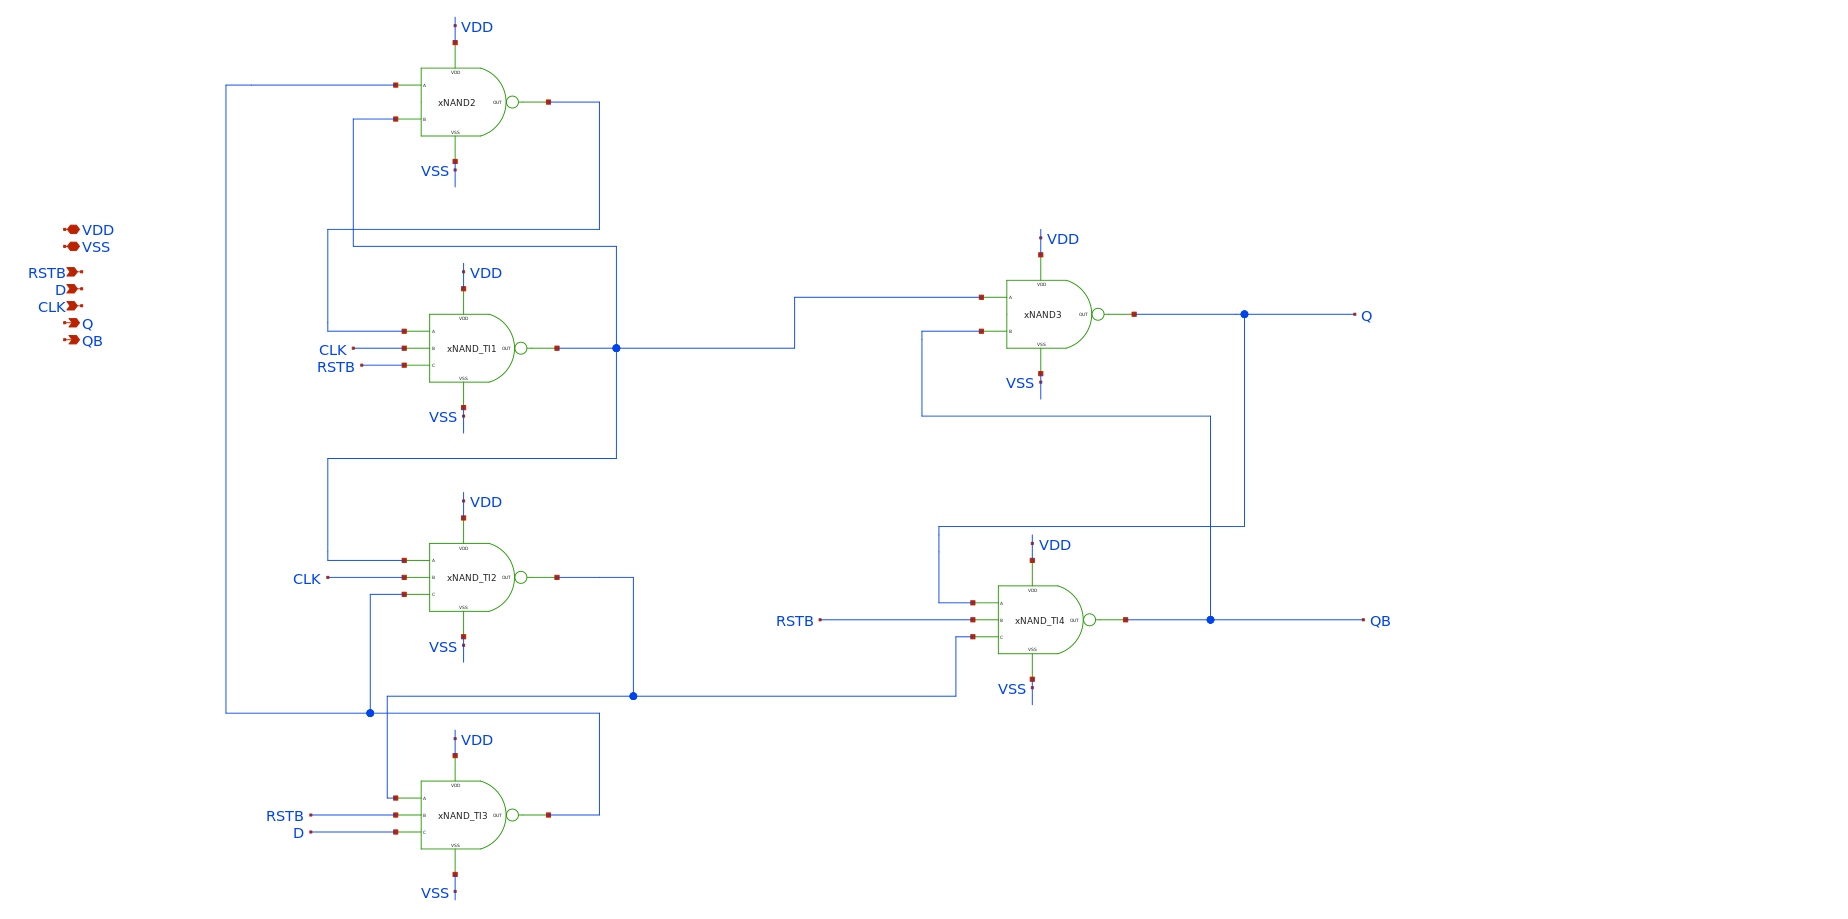

In [14]:
Image('./images/DFF.png')

### **Ring Oscillator**

Ring oscillator consists of back to back connected inverters in a chain suh that the number of inverters N are odd. The time period of oscillation is given by the equation: </br>


~~~
> Fosc=1/(2xNxTd)
~~~
where </br>
~~~
N is the number of inverters in the chain (must be odd)</br>
Td is the propagation delay</br>
Fosc is the Oscillation Ftequency</br>
~~~


The design ring oscillator at a specific frequency we must adjust the propagation delay of the inverter. The propagation delay of the inverter designed in the previous section cen be found using following testbench. The testbench contains 3 inverters, and the delay is measured between the **OUT** and **OUT1** nodes to correctly simulate the **FAN OUT of 1** inverter delay. FO1 delay is important since in the ring oscillator, each inverter will be driving one single inverter at its output.

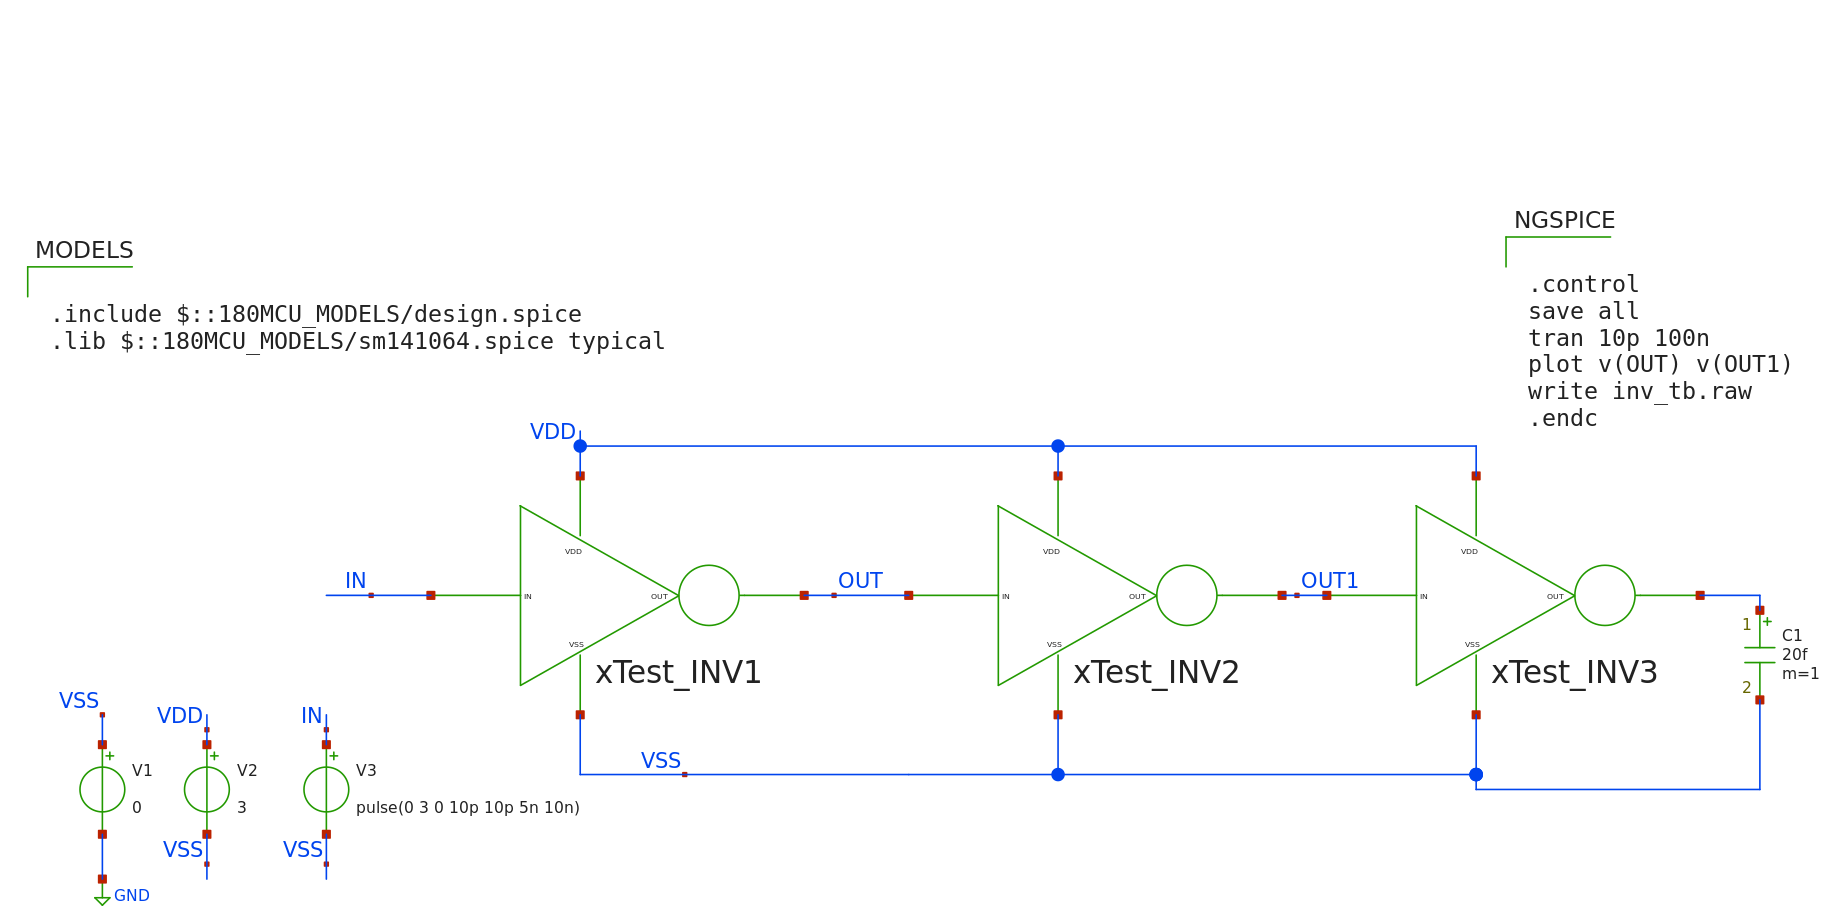

In [16]:
Image('./images/inv_tran.png')

In [17]:
%%writefile inv_tran.spice
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/Test_INV_tb.sch
**.subckt Test_INV_tb
C1 net1 VSS 20f m=1
V1 VSS GND 0
.save i(v1)
V2 VDD VSS 3
.save i(v2)
V3 IN VSS pulse(0 3 0 10p 10p 5n 10n)
.save i(v3)
xTest_INV1 VDD VSS IN OUT Test_INV
xTest_INV2 VDD VSS OUT OUT1 Test_INV
xTest_INV3 VDD VSS OUT1 net1 Test_INV
**** begin user architecture code

.include ./ngspice/design.spice
.lib ./ngspice/sm141064.spice typical



.control
save all
tran 10p 5.2n 5n
*plot v(OUT) v(OUT1)
WRDATA inv_tran.csv v(OUT) v(OUT1)
.endc


**** end user architecture code
**.ends

* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/Test_INV.sym # of pins=4
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/Test_INV.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/Test_INV.sch
.subckt Test_INV VDD VSS IN OUT
*.ipin IN
*.iopin VDD
*.iopin VSS
*.opin OUT
XM1 OUT IN VSS VSS nmos_3p3 L=0.28u W=0.8u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM2 OUT IN VDD VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
.ends

.GLOBAL GND
.end


Writing inv_tran.spice


In [18]:
!ngspice -b inv_tran.spice

ngspice: /content/conda-env/bin/../lib/libtinfo.so.6: no version information available (required by ngspice)

Note: No compatibility mode selected!


Circuit: ** sch_path: /home/shahidosic/gfprojects/pll/xschem/test_inv_tb.sch

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
net1                                         3
vss                                          0
vdd                                          3
in                                           0
out                                          3
out1                               6.30524e-09
v3#branch                                    0
v2#branch                         -9.92996e-12
v1#branch                          1.48027e-15

 Reference value :  5.00000e-09
No. of Data Rows : 57
Note: No ".plot", ".print", or ".fourier" lines; no simulations run


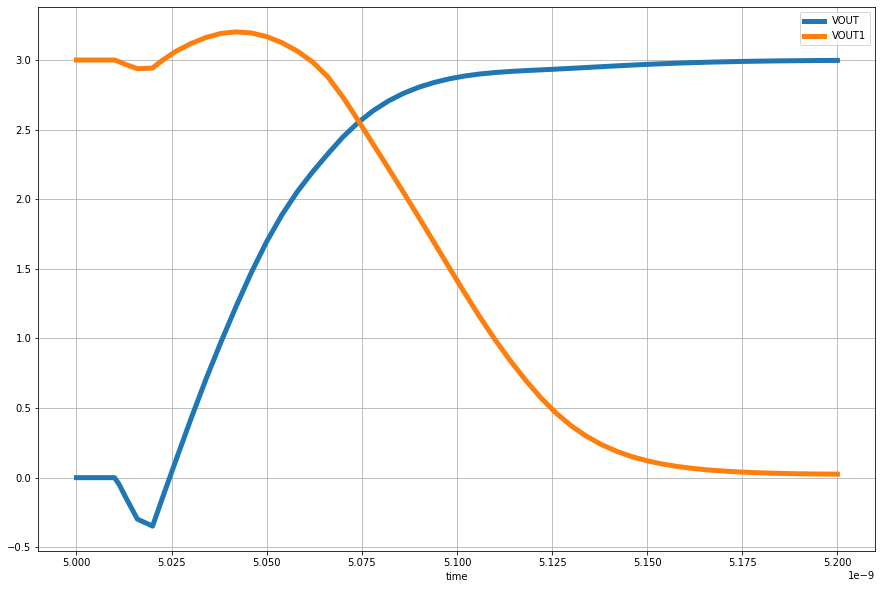

In [19]:
df = pd.read_csv("./inv_tran.csv", delim_whitespace=True, header=None)
df.columns = ["time", "VOUT","time2", "VOUT1"]
#df
df.plot(x="time", y=["VOUT","VOUT1"], grid=True, figsize=(15,10), linewidth=5)
plt.show()

As can be observed from the previous figure, the propgation delay is around 50ps. If 7 of these inverters are connected back to back, we will have a ring oscillator operating at 1/(2x7x50ps) = 1.43GHz. Such a scheme is implemented in the following schematic.

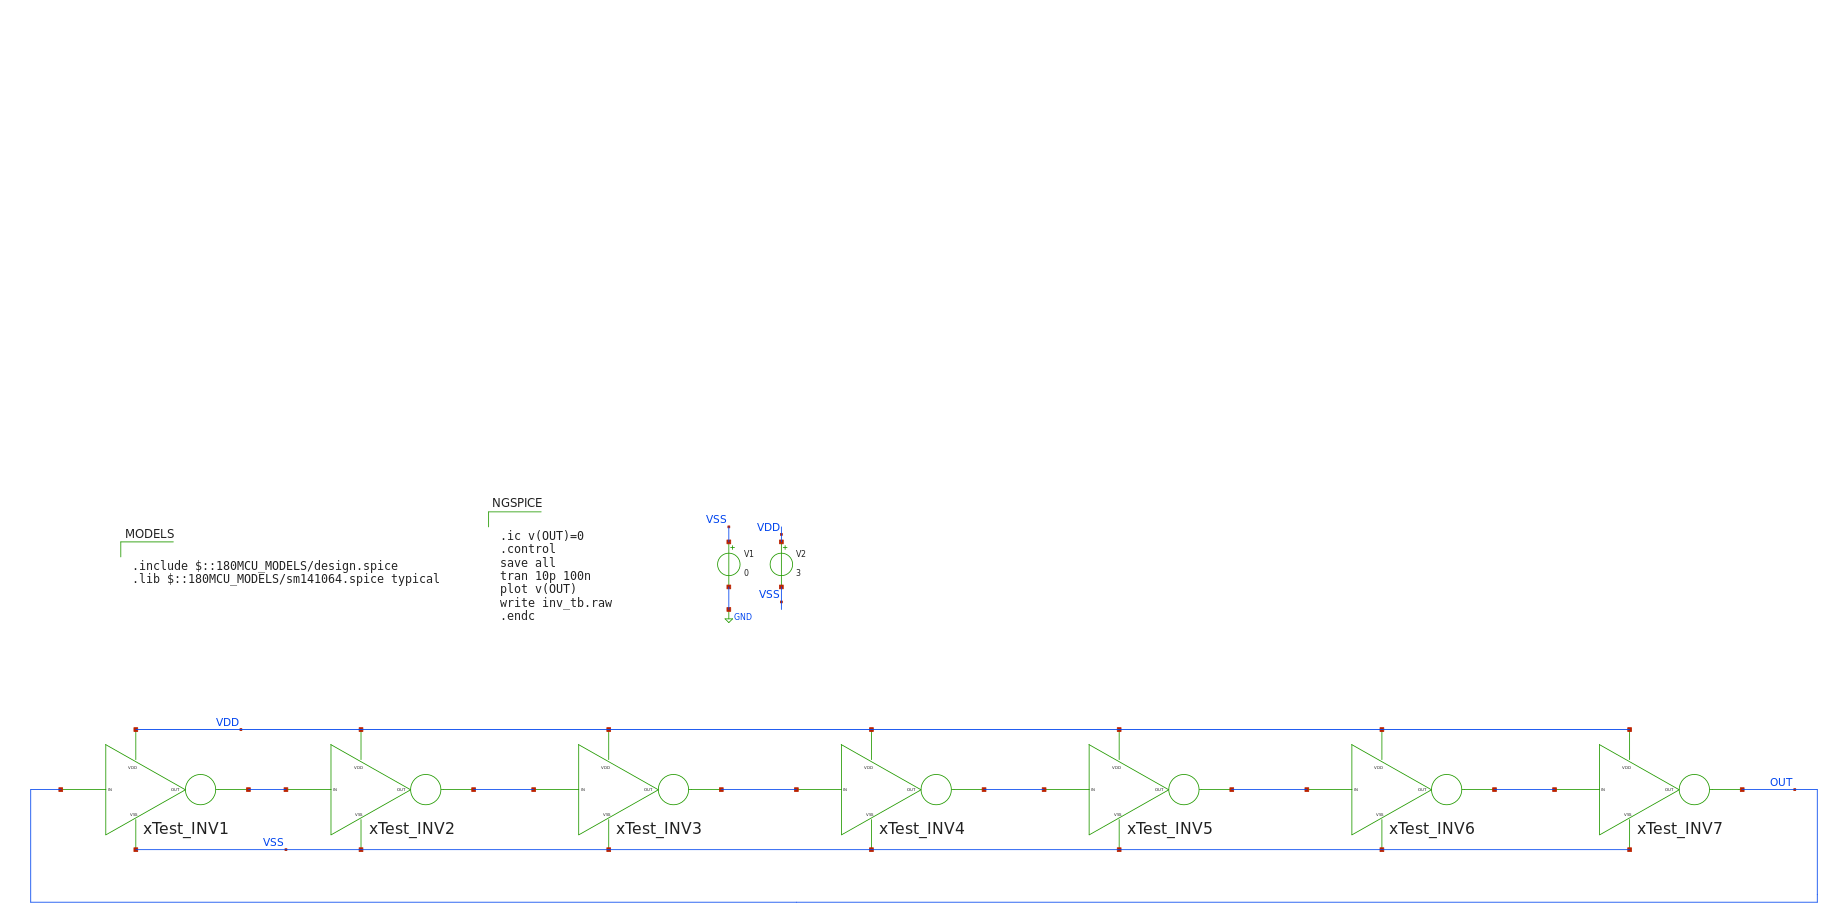

In [21]:
Image('./images/Oscillator.png')

In [22]:
%%writefile osc.spice
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/Oscillator.sch
**.subckt Oscillator
V1 VSS GND 0
.save i(v1)
V2 VDD VSS 3
.save i(v2)
xTest_INV1 VDD VSS OUT net1 Test_INV
xTest_INV2 VDD VSS net1 net2 Test_INV
xTest_INV3 VDD VSS net2 net3 Test_INV
xTest_INV4 VDD VSS net3 net4 Test_INV
xTest_INV5 VDD VSS net4 net5 Test_INV
xTest_INV6 VDD VSS net5 net6 Test_INV
xTest_INV7 VDD VSS net6 OUT Test_INV
**** begin user architecture code

.include ./ngspice/design.spice
.lib ./ngspice/sm141064.spice typical



.ic v(OUT)=0
.control
save all
tran 10p 2n
*plot v(OUT)
WRDATA osc.csv v(OUT)
.endc


**** end user architecture code
**.ends

* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/Test_INV.sym # of pins=4
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/Test_INV.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/Test_INV.sch
.subckt Test_INV VDD VSS IN OUT
*.ipin IN
*.iopin VDD
*.iopin VSS
*.opin OUT
XM1 OUT IN VSS VSS nmos_3p3 L=0.28u W=0.8u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM2 OUT IN VDD VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
.ends

.GLOBAL GND
.end


Writing osc.spice


In [23]:
!ngspice -b osc.spice

ngspice: /content/conda-env/bin/../lib/libtinfo.so.6: no version information available (required by ngspice)

Note: No compatibility mode selected!


Circuit: ** sch_path: /home/shahidosic/gfprojects/pll/xschem/oscillator.sch

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
vss                                          0
vdd                                          3
net1                                         3
out                                          0
net2                               6.30524e-09
net3                                         3
net4                               6.30524e-09
net5                                         3
net6                               6.30524e-09
v2#branch                         -0.000500649
v1#branch                         -0.000500649

 Reference value :  0.00000e+00
No. of Data Rows

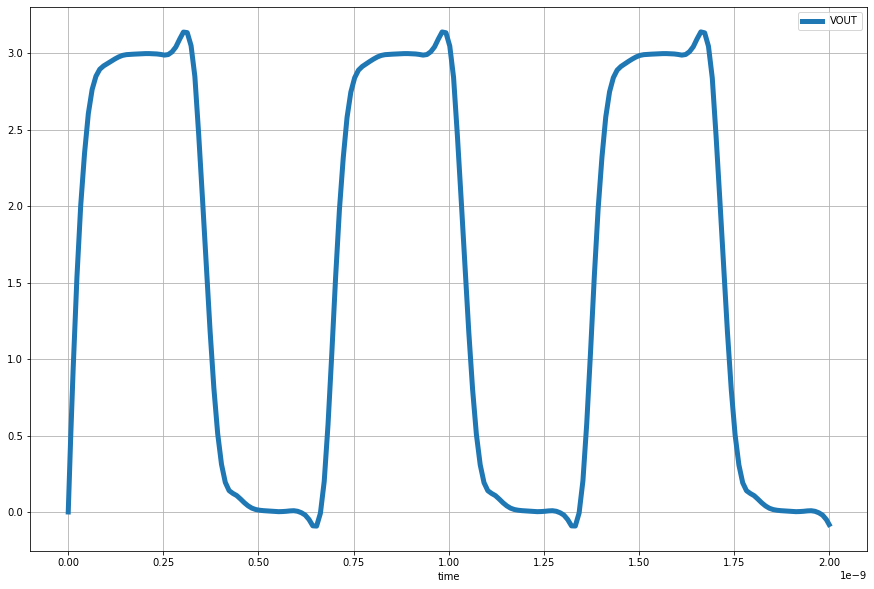

In [24]:
df = pd.read_csv("./osc.csv", delim_whitespace=True, header=None)
df.columns = ["time", "VOUT"]
#df
df.plot(x="time", y="VOUT", grid=True, figsize=(15,10), linewidth=5)
plt.show()

As predicted by our calulcation the oscillation frequency is indeed close to 1.4GHz. Since we want our ring oscilator to work at 128MHz, we need to increase the propgation delay of the individual inverters. This can be achieved by increasing length of the transistors. The modified inverter is shown in figure below.  

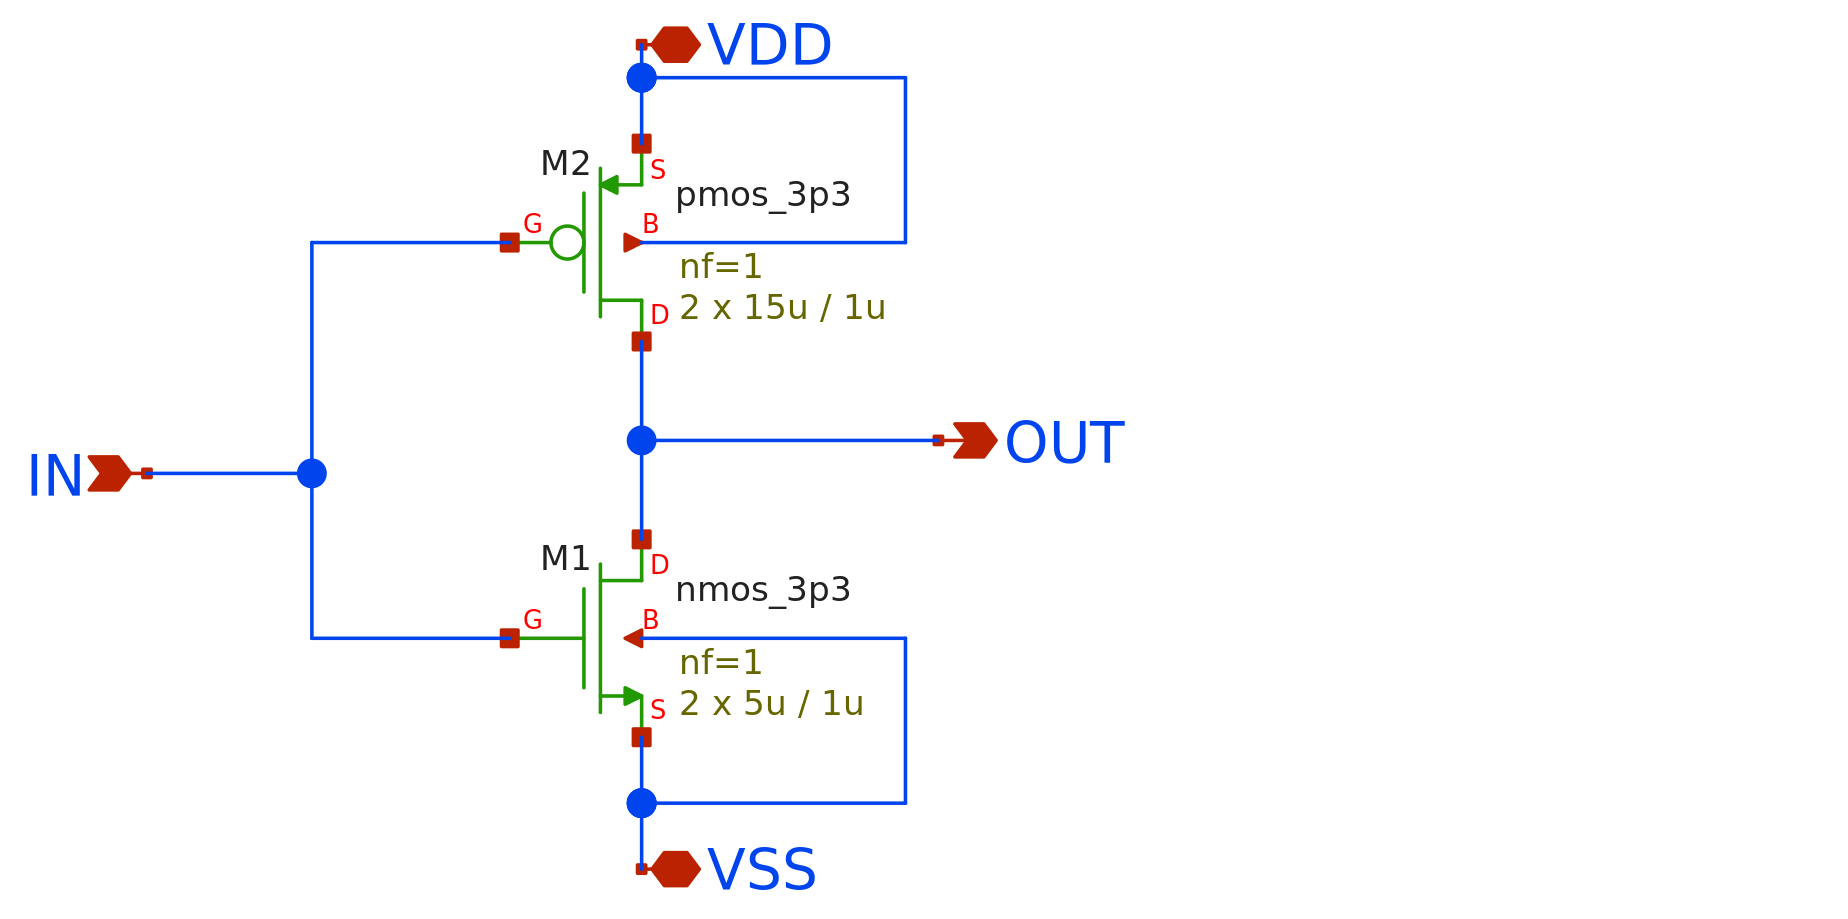

In [26]:
Image('./images/inv_mod.png')

Along with the increase in transistors sizes, one other modification has been made to make the simple ring oscillator into a voltage controlled oscillator. The schematic is shown in figure below. The seven inverters are connected back to back as before, but an additional PMOS and NMOS transistors have been added to them. These PMOS and NMOS transistors vary the PULL UP/PULL DOWN restances which increases/decreases the propgation delay. Since oscillation frequency varies inversely with the propagation delay, we achieve frequency tuning with voltage

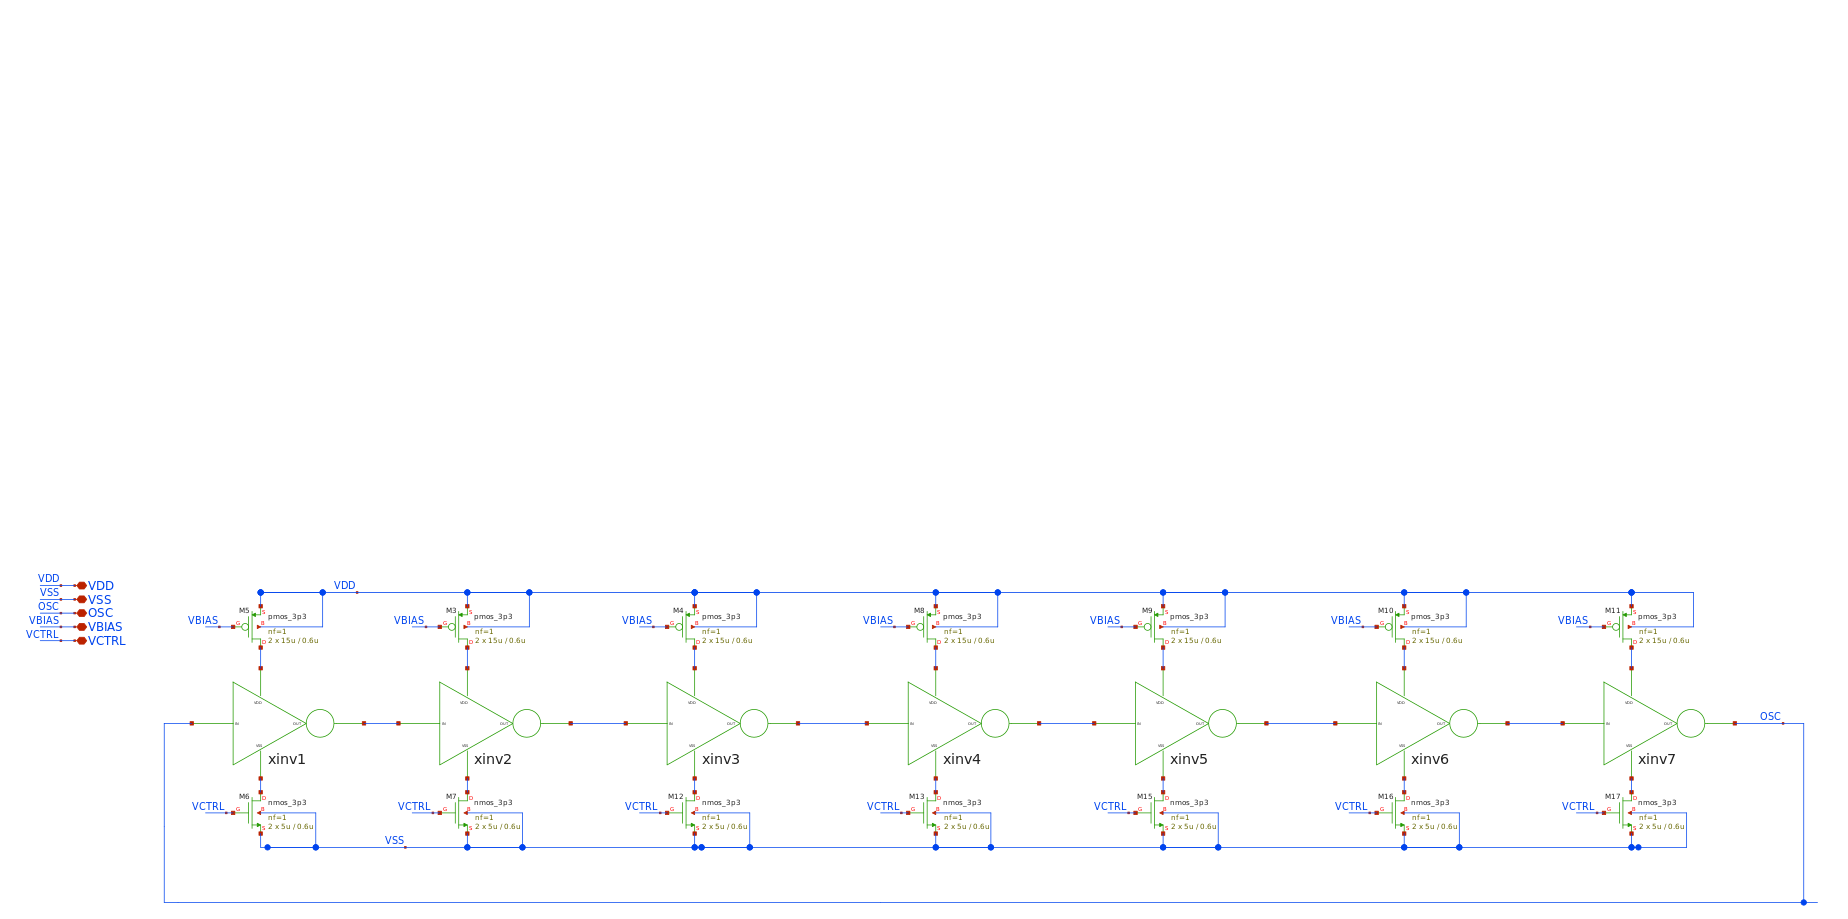

In [28]:
Image('./images/VCO.png')

The test bench for the circuit is shown in figure below

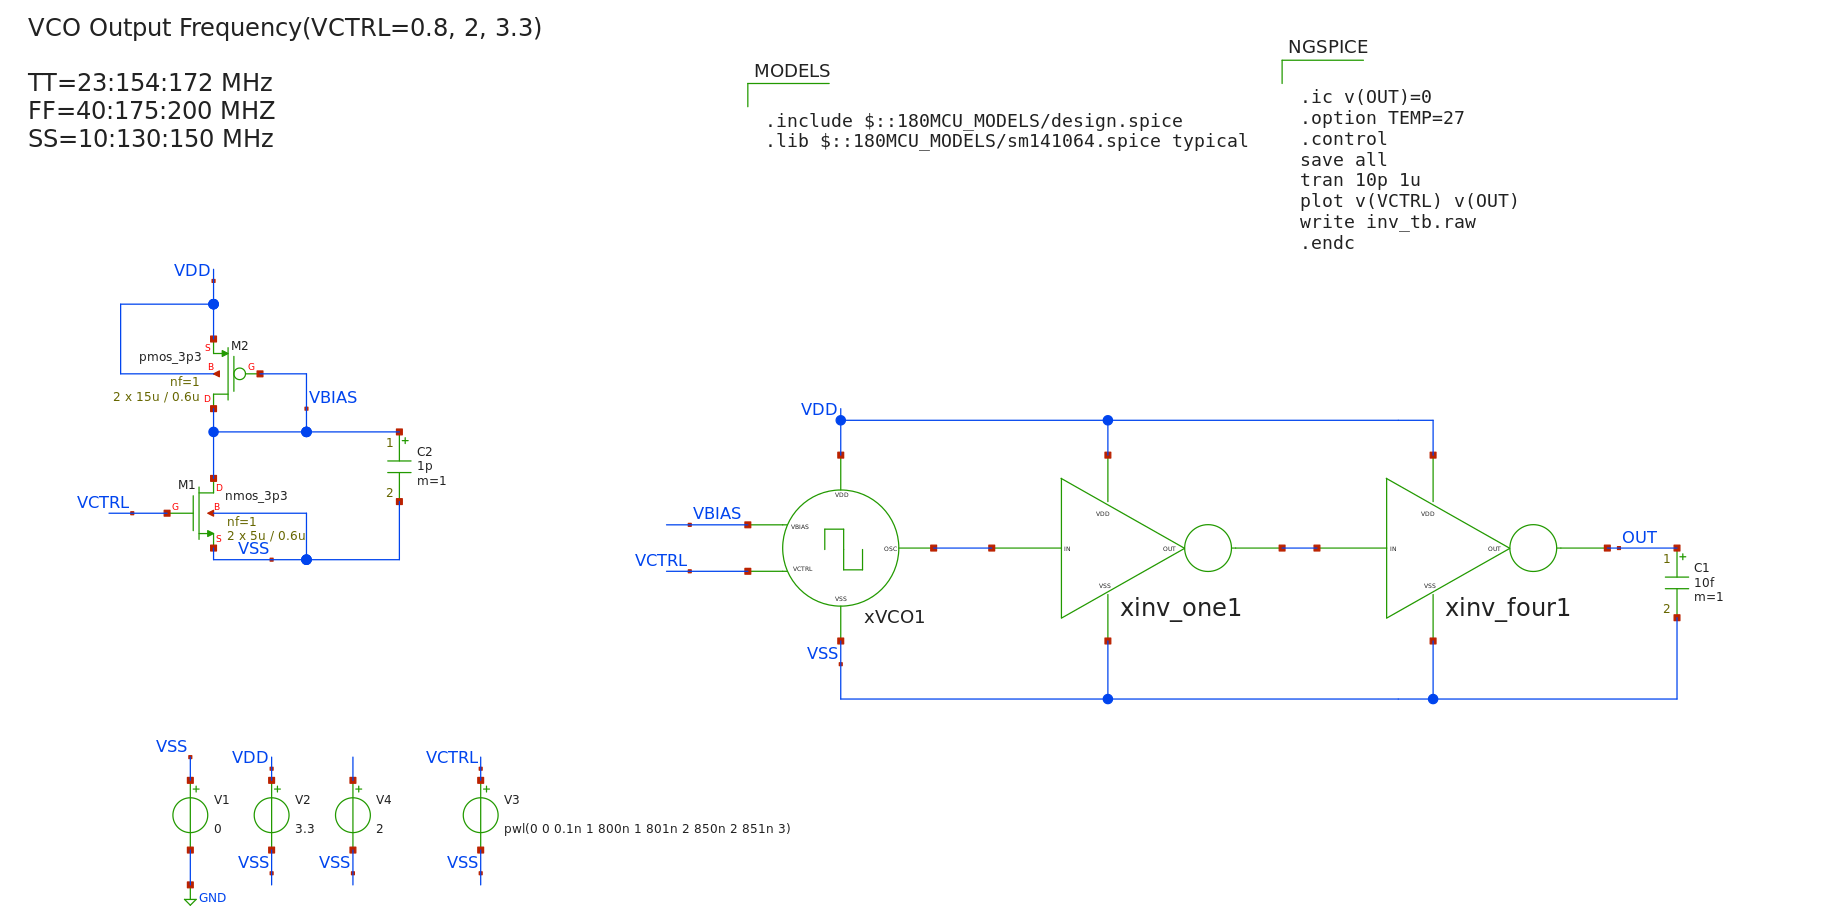

In [30]:
Image('./images/VCO_tb.png')

In [31]:
%%writefile VCO_tb.spice
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/VCO_tb.sch
**.subckt VCO_tb
V1 VSS GND 0
.save i(v1)
V2 VDD VSS 3.3
.save i(v2)
XM1 VBIAS VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM2 VBIAS VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
V4 net1 VSS 2
.save i(v4)
C2 VBIAS VSS 1p m=1
V3 VCTRL VSS pwl(0 0 0.1n 1 100n 1 101n 1.5 120n 1.5 121n 3)
.save i(v3)
xVCO1 VDD VSS VBIAS VCTRL net3 VCO
xinv_one1 VDD VSS net3 net2 INV_one
xinv_four1 VDD VSS net2 OUT INV_four
C1 OUT VSS 10f m=1
**** begin user architecture code

.include ./ngspice/design.spice
.lib ./ngspice/sm141064.spice typical



.ic v(OUT)=0
.option TEMP=27
.control
save all
tran 10p 150n
WRDATA VCO.csv v(VCTRL) v(OUT)
.endc


**** end user architecture code
**.ends

* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/VCO.sym # of pins=5
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/VCO.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/VCO.sch
.subckt VCO VDD VSS VBIAS VCTRL OSC
*.iopin VDD
*.iopin VSS
*.iopin OSC
*.iopin VBIAS
*.iopin VCTRL
XM5 net7 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM3 net8 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM4 net9 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM8 net10 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM9 net11 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM10 net12 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM11 net13 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM6 net14 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM7 net15 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM12 net16 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM13 net17 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM15 net18 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM16 net19 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM17 net20 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
xinv1 net7 net14 OSC net1 inv
xinv2 net8 net15 net1 net2 inv
xinv3 net9 net16 net2 net3 inv
xinv4 net10 net17 net3 net4 inv
xinv5 net11 net18 net4 net5 inv
xinv6 net12 net19 net5 net6 inv
xinv7 net13 net20 net6 OSC inv
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/INV_one.sym # of pins=4
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/INV_one.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/INV_one.sch
.subckt INV_one VDD VSS IN OUT
*.ipin IN
*.iopin VDD
*.iopin VSS
*.opin OUT
XM1 OUT IN VSS VSS nmos_3p3 L=0.28u W=0.8u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM2 OUT IN VDD VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/INV_four.sym # of pins=4
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/INV_four.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/INV_four.sch
.subckt INV_four VDD VSS IN OUT
*.iopin VDD
*.iopin VSS
*.ipin IN
*.opin OUT
xinv_one1 VDD VSS IN OUT INV_one
xinv_one2 VDD VSS IN OUT INV_one
xinv_one3 VDD VSS IN OUT INV_one
xinv_one4 VDD VSS IN OUT INV_one
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/inv.sym # of pins=4
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/inv.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/inv.sch
.subckt inv VDD VSS IN OUT
*.ipin IN
*.iopin VDD
*.iopin VSS
*.opin OUT
XM1 OUT IN VSS VSS nmos_3p3 L=1u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM2 OUT IN VDD VDD pmos_3p3 L=1u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
.ends

.GLOBAL GND
.end


Writing VCO_tb.spice


In [32]:
!ngspice -b VCO_tb.spice

ngspice: /content/conda-env/bin/../lib/libtinfo.so.6: no version information available (required by ngspice)

Note: No compatibility mode selected!


Circuit: ** sch_path: /home/shahidosic/gfprojects/pll/xschem/vco_tb.sch

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000


Initial Transient Solution
--------------------------

Node                                   Voltage
----                                   -------
vss                                          0
vdd                                        3.3
vbias                                  3.03631
vctrl                                        0
net1                                         2
xvco1.net7                             3.21053
xvco1.net8                             3.21142
xvco1.net9                             3.20908
xvco1.net10                             3.2113
xvco1.net11                            3.20753
xvco1.net12                            3.20941
xvco1.net13                            3.20786
xvco1.

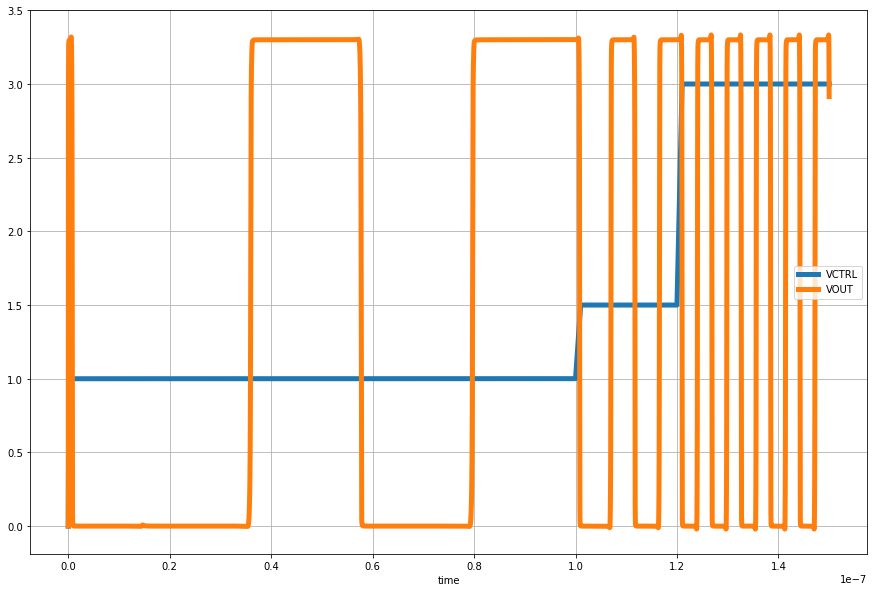

In [33]:
df = pd.read_csv("./VCO.csv", delim_whitespace=True, header=None)
df.columns = ["time", "VCTRL","time1", "VOUT"]
#df
df.plot(x="time", y=["VCTRL","VOUT"], grid=True, figsize=(15,10), linewidth=5)
plt.show()

We can see that from the previous figure that the output frequency of the VCO varies directly with the voltage **VCTRL**. The oscillation frequency can be varied from 40MHz to 150MHz across all process corners.

With the VCO designed, we next design Phase-Frequency detector. The classical phase frequency detector circuit found in literature is shown below (Xschem Implementation). The circuit detects mismatches in both phase and frequency.

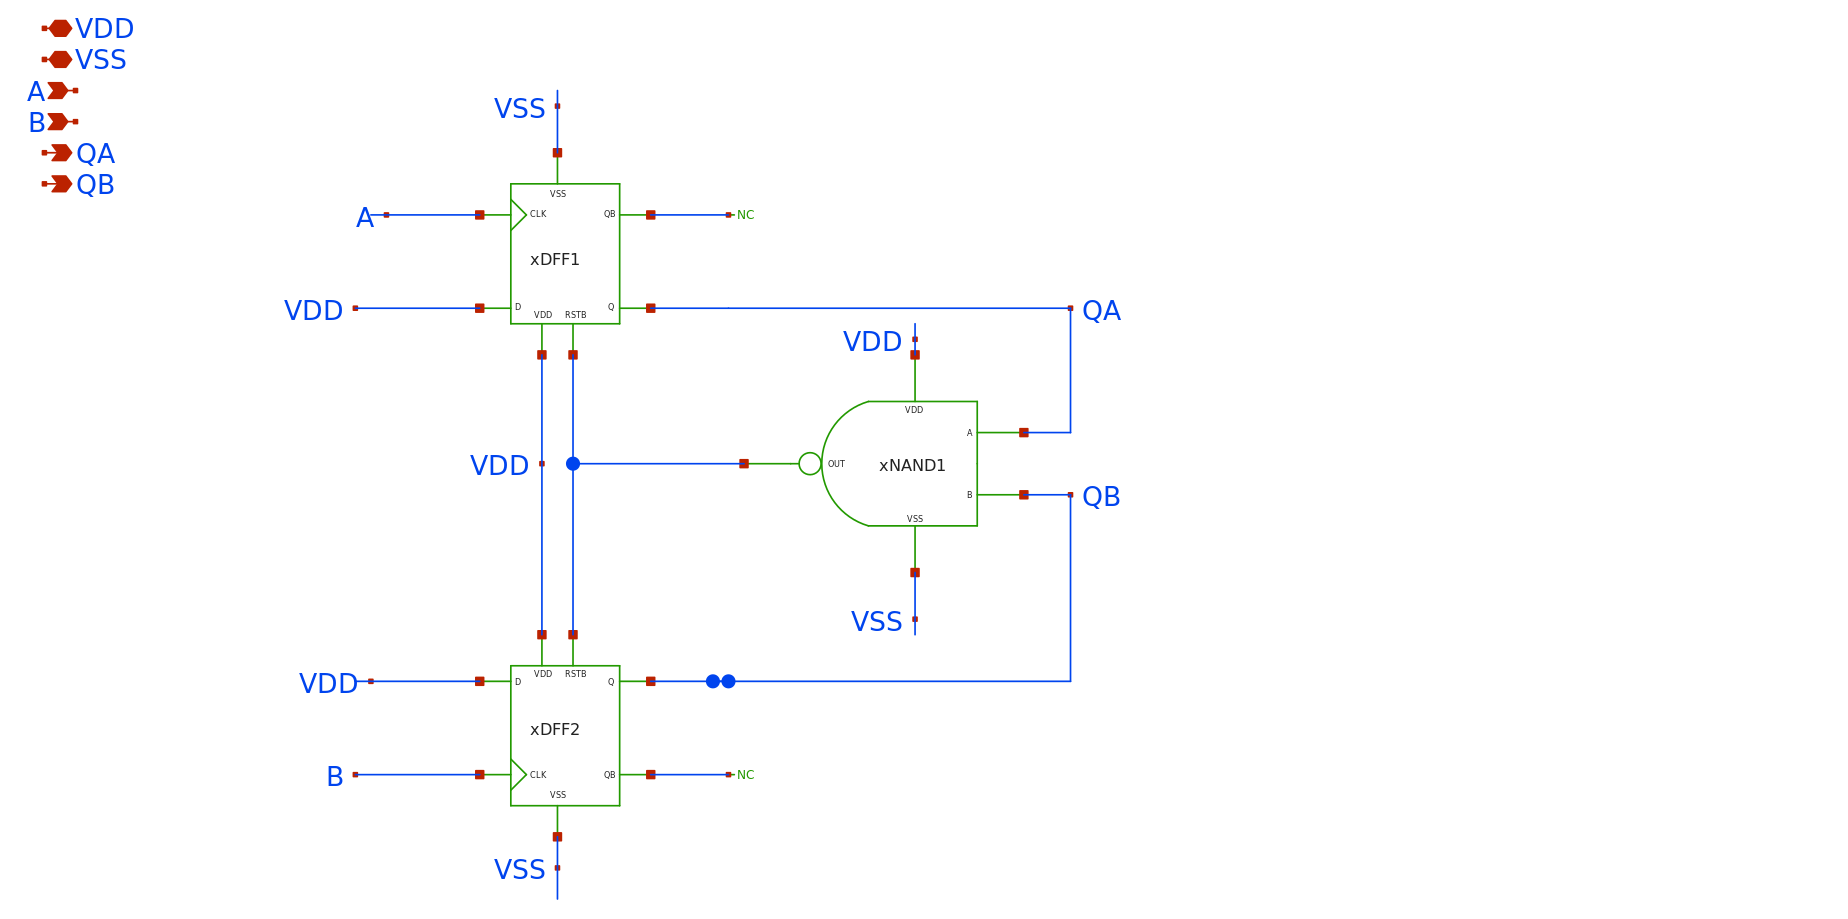

In [35]:
Image('./images/PFD.png')

The behaviour of PFD circuit is tedious to test in isolation. We will see it in action once the complete PLL is simulated.

The next schematic to design is the frequency divider. Since we want to lock to an external 2MHz clock and generate a 128MHz on-chip clock, we need a **divide by 64** block in our PLL. This is simply a 6-bit counter which can be easily designed with D-FLip flops as shown in figure below. Each DFF divides the input clock by 2, since we have 6 of them , the output is divided by 2^6=64. The input of this circuit will be from the output of the VCO. The output of this ircuit will go to PFD circuit. At the PFD, VCO/64 clock and reference input clock will be compared.   

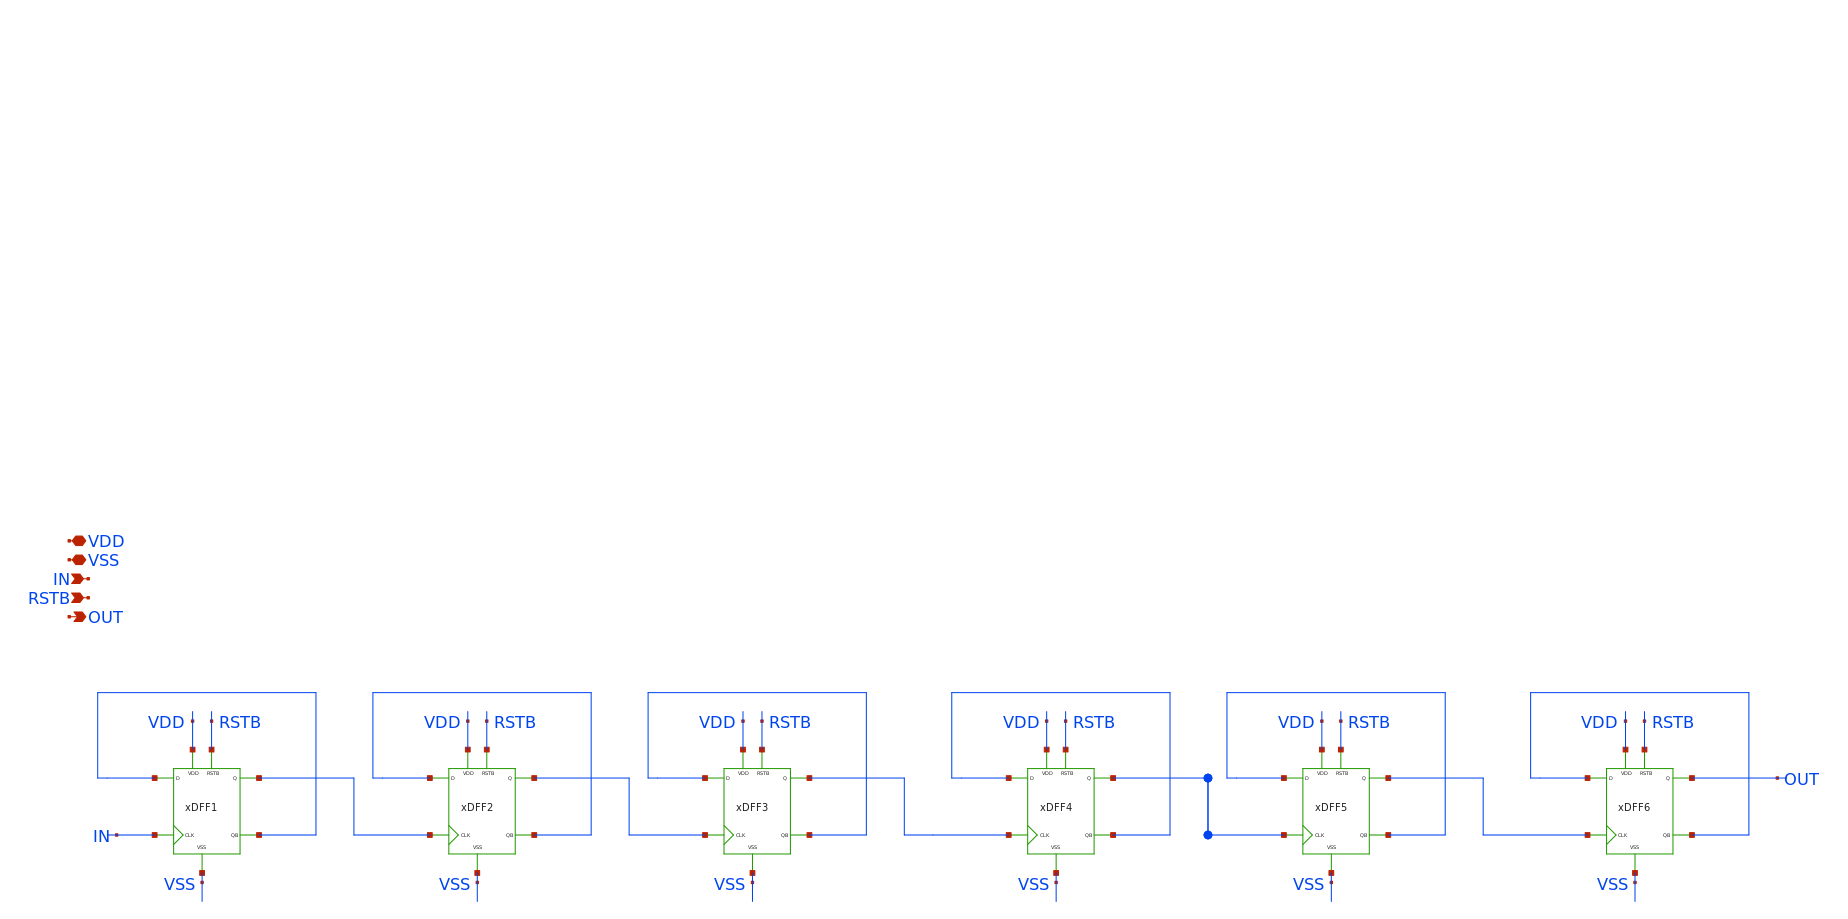

In [37]:
Image('./images/FBY64.png')

The next schematc is for charge pump circuit. Depending on the output from the PFD circuit, a capacitor is either charged or discharged by the charge pump circuit. A simple charge pump circuit (xschem implementation) is shown below. The PFD outputs QA and QB, when high, charge or discharge the capacitor C1 through resistor R1. PMOS transistors M9 and M10 are there to pull VCTRL to VDD when reset signal is applied to circuit. Transmission Gate xTG2 isolates the charge pump from the VCTRL node when reset is applied. During reset loop is open and VCO is operating at maximum frequency (free-running) since VCTRL is at its max value. Capacitor C2 is there to filter out any ripples in the Vbias voltage.

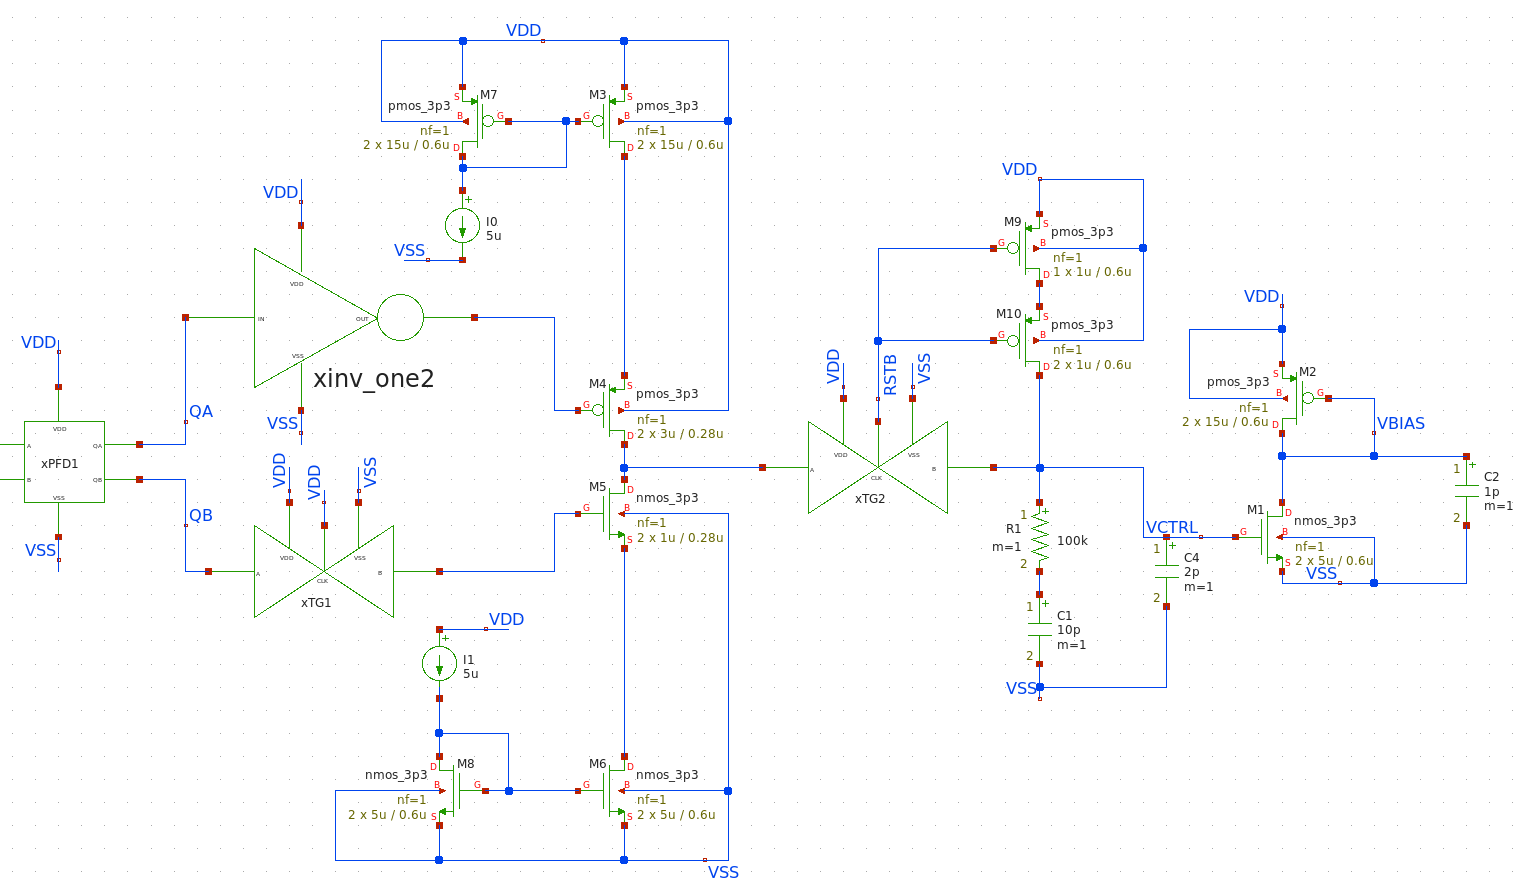

In [38]:
Image('./images/CP.PNG')

## **Complete Clock Multiplier PLL Schematic**

The complete Clock multiplier PLL schematic is made by combining all the subcircuits from previous sections. The xschem mplementation is shown in following figure. The circuit is initially in reset (active low) state, which causes the TG in the charge pump to break the loop. The VCTRL is pulled to VDD and the VCO oscillates at maximum free-running frequency. Once the reset signal is released, the loop is complete again. The FBY64 circuit divides the clock at the output of VCO and feeds it at one of the inputs of the PFD circuit. The other input of PFD is the reference clock at 2MHz. The phase/frequency of these two signals is compared and the charge pump actions produces the VCTRL to tune the Fosc back at 128MHz (Fosc will be higher than 128MHz initially since the VCTRL was at VDD). This will also be indicated by the fact that in locked state, both inputs of PFD circuit will have same phase and frequency.

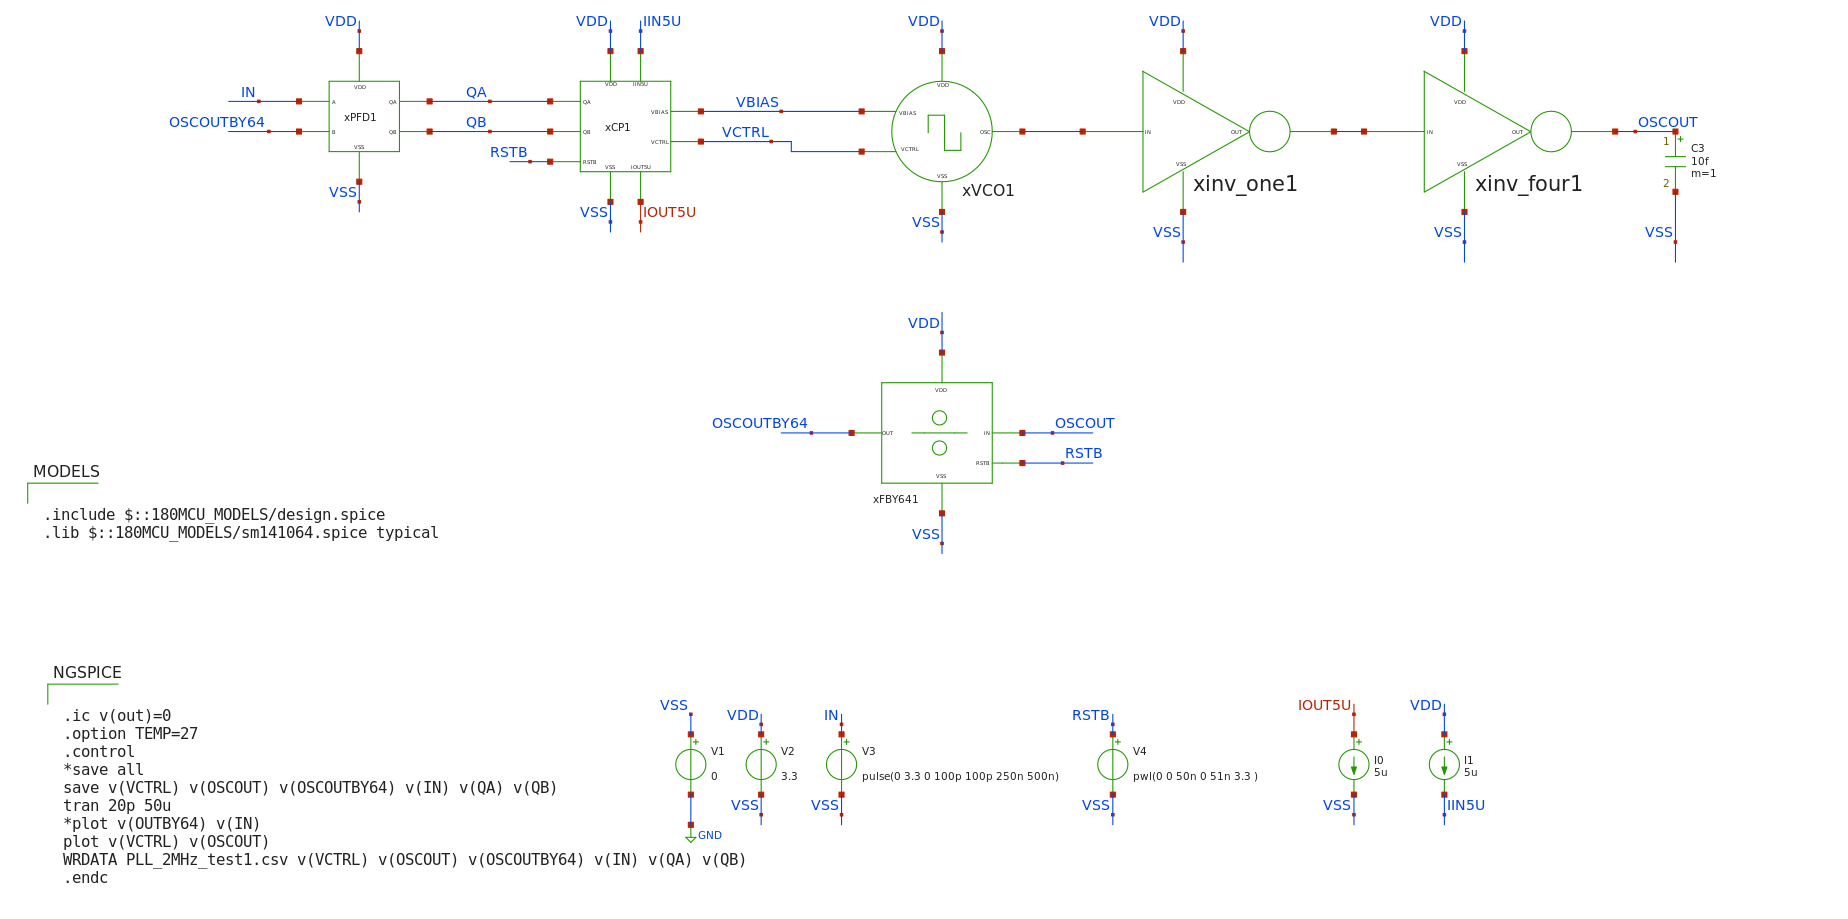

In [39]:
Image('./images/PLL_TOP.png')

In [40]:
%%writefile PLL_TOP.spice
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/PLL_TOP.sch
**.subckt PLL_TOP
xPFD1 VDD VSS IN OSCOUTBY64 QA QB PFD
xCP1 VDD IIN5U VBIAS VCTRL IOUT5U VSS RSTB QB QA CP
xVCO1 VDD VSS VBIAS VCTRL net1 VCO
xinv_one1 VDD VSS net1 net2 INV_one
xinv_four1 VDD VSS net2 OSCOUT INV_four
C3 OSCOUT VSS 10f m=1
xFBY641 VDD VSS OSCOUT RSTB OSCOUTBY64 FBY64
V1 VSS GND 0
.save i(v1)
V2 VDD VSS 3.3
.save i(v2)
V3 IN VSS pulse(0 3.3 0 100p 100p 250n 500n)
.save i(v3)
V4 RSTB VSS pwl(0 0 50n 0 51n 3.3 )
.save i(v4)
I0 IOUT5U VSS 5u
I1 VDD IIN5U 5u
**** begin user architecture code

.include ./ngspice/design.spice
.lib ./ngspice/sm141064.spice typical



.ic v(out)=0
.option TEMP=27
.control
*save all
save v(VCTRL) v(OSCOUT) v(OSCOUTBY64) v(IN) v(QA) v(QB)
tran 20p 20u
*plot v(OUTBY64) v(IN)
*plot v(VCTRL) v(OSCOUT)
WRDATA PLL_TOP.csv v(VCTRL) v(OSCOUT) v(OSCOUTBY64) v(IN) v(QA) v(QB)
.endc


**** end user architecture code
**.ends

* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/PFD.sym # of pins=6
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/PFD.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/PFD.sch
.subckt PFD VDD VSS A B QA QB
*.ipin A
*.iopin VDD
*.iopin VSS
*.opin QA
*.ipin B
*.opin QB
xDFF1 VDD VSS VDD A QA net2 net1 DFF
xDFF2 VDD VSS VDD B QB net3 net1 DFF
xNAND1 VDD VSS QA net1 QB NAND
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/CP.sym # of pins=9
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/CP.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/CP.sch
.subckt CP VDD IIN5U VBIAS VCTRL IOUT5U VSS RSTB QB QA
*.iopin VDD
*.iopin VCTRL
*.ipin RSTB
*.ipin QA
*.ipin QB
*.iopin IIN5U
*.iopin IOUT5U
*.iopin VSS
*.iopin VBIAS
XM1 VBIAS VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM2 VBIAS VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
C2 VBIAS VSS 1p m=1
xinv_one2 VDD VSS QA net2 INV_one
XM3 net3 IOUT5U VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM4 net4 net2 net3 VDD pmos_3p3 L=0.28u W=3u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM5 net4 net1 net5 VSS nmos_3p3 L=0.28u W=1u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM6 net5 IIN5U VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM7 IOUT5U IOUT5U VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM8 IIN5U IIN5U VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
R1 VCTRL net6 100k m=1
C1 net6 VSS 10p m=1
XM9 net7 RSTB VDD VDD pmos_3p3 L=0.6u W=1u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM10 VCTRL RSTB net7 VDD pmos_3p3 L=0.6u W=1u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
xTG1 VDD VSS VDD QB net1 TG
xTG2 VDD VSS RSTB net4 VCTRL TG
C4 VCTRL VSS 2p m=1
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/VCO.sym # of pins=5
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/VCO.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/VCO.sch
.subckt VCO VDD VSS VBIAS VCTRL OSC
*.iopin VDD
*.iopin VSS
*.iopin OSC
*.iopin VBIAS
*.iopin VCTRL
XM5 net7 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM3 net8 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM4 net9 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM8 net10 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM9 net11 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM10 net12 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM11 net13 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM6 net14 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM7 net15 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM12 net16 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM13 net17 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM15 net18 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM16 net19 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM17 net20 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
xinv1 net7 net14 OSC net1 inv
xinv2 net8 net15 net1 net2 inv
xinv3 net9 net16 net2 net3 inv
xinv4 net10 net17 net3 net4 inv
xinv5 net11 net18 net4 net5 inv
xinv6 net12 net19 net5 net6 inv
xinv7 net13 net20 net6 OSC inv
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/INV_one.sym # of pins=4
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/INV_one.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/INV_one.sch
.subckt INV_one VDD VSS IN OUT
*.ipin IN
*.iopin VDD
*.iopin VSS
*.opin OUT
XM1 OUT IN VSS VSS nmos_3p3 L=0.28u W=0.8u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM2 OUT IN VDD VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/INV_four.sym # of pins=4
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/INV_four.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/INV_four.sch
.subckt INV_four VDD VSS IN OUT
*.iopin VDD
*.iopin VSS
*.ipin IN
*.opin OUT
xinv_one1 VDD VSS IN OUT INV_one
xinv_one2 VDD VSS IN OUT INV_one
xinv_one3 VDD VSS IN OUT INV_one
xinv_one4 VDD VSS IN OUT INV_one
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/FBY64.sym # of pins=5
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/FBY64.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/FBY64.sch
.subckt FBY64 VDD VSS IN RSTB OUT
*.ipin IN
*.iopin VDD
*.iopin VSS
*.opin OUT
*.ipin RSTB
xDFF1 VDD VSS net1 IN net2 net1 RSTB DFF
xDFF2 VDD VSS net3 net2 net4 net3 RSTB DFF
xDFF3 VDD VSS net5 net4 net6 net5 RSTB DFF
xDFF4 VDD VSS net7 net6 net8 net7 RSTB DFF
xDFF5 VDD VSS net9 net8 net10 net9 RSTB DFF
xDFF6 VDD VSS net11 net10 OUT net11 RSTB DFF
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/DFF.sym # of pins=7
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/DFF.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/DFF.sch
.subckt DFF VDD VSS D CLK Q QB RSTB
*.ipin D
*.iopin VDD
*.iopin VSS
*.opin Q
*.ipin CLK
*.opin QB
*.ipin RSTB
xNAND2 VDD VSS net1 net4 net3 NAND
xNAND_TI1 VDD VSS net4 net3 RSTB CLK NAND_TI
xNAND_TI2 VDD VSS net3 net2 net1 CLK NAND_TI
xNAND_TI3 VDD VSS net2 net1 D RSTB NAND_TI
xNAND3 VDD VSS net3 Q QB NAND
xNAND_TI4 VDD VSS Q QB net2 RSTB NAND_TI
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/NAND.sym # of pins=5
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/NAND.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/NAND.sch
.subckt NAND VDD VSS A OUT B
*.ipin A
*.iopin VDD
*.iopin VSS
*.opin OUT
*.ipin B
XM1 OUT A net1 VSS nmos_3p3 L=0.28u W=1.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM2 OUT A VDD VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM3 net1 B VSS VSS nmos_3p3 L=0.28u W=1.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM4 OUT B VDD VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/TG.sym # of pins=5
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/TG.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/TG.sch
.subckt TG VDD VSS CLK A B
*.iopin A
*.iopin VDD
*.iopin VSS
*.iopin B
*.ipin CLK
XM3 A CLKB B VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM4 A CLK B VSS nmos_3p3 L=0.28u W=0.8u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
xinv_one1 VDD VSS CLK CLKB INV_one
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/inv.sym # of pins=4
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/inv.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/inv.sch
.subckt inv VDD VSS IN OUT
*.ipin IN
*.iopin VDD
*.iopin VSS
*.opin OUT
XM1 OUT IN VSS VSS nmos_3p3 L=1u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM2 OUT IN VDD VDD pmos_3p3 L=1u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/NAND_TI.sym # of pins=6
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/NAND_TI.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/NAND_TI.sch
.subckt NAND_TI VDD VSS A OUT C B
*.ipin A
*.iopin VDD
*.iopin VSS
*.opin OUT
*.ipin B
*.ipin C
XM1 OUT A net1 VSS nmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM2 OUT A VDD VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM3 net1 B net2 VSS nmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM4 OUT B VDD VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM5 OUT C VDD VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM6 net2 C VSS VSS nmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
.ends

.GLOBAL GND
.end


Writing PLL_TOP.spice


# **Be Advised: Running following simulation will take upto 45 minutes !!!**

In [41]:
!ngspice -b  PLL_TOP.spice

ngspice: /content/conda-env/bin/../lib/libtinfo.so.6: no version information available (required by ngspice)

Note: No compatibility mode selected!


Circuit: ** sch_path: /home/shahidosic/gfprojects/pll/xschem/pll_top.sch

   Please check line .ic v(out)=0

Doing analysis at TEMP = 27.000000 and TNOM = 27.000000

Note: Starting dynamic gmin stepping
Trying gmin =   1.0000E-03 Note: One successful gmin step
Trying gmin =   1.0000E-04 Note: One successful gmin step
Trying gmin =   1.0000E-05 Note: One successful gmin step
Trying gmin =   1.0000E-06 Note: One successful gmin step
Trying gmin =   1.0000E-07 Note: One successful gmin step
Trying gmin =   1.0000E-08 Warning: Further gmin increment
Trying gmin =   5.6234E-08 Note: One successful gmin step
Trying gmin =   2.3714E-08 Note: One successful gmin step
Trying gmin =   6.4938E-09 Warning: Further gmin increment
Trying gmin =   1.7154E-08 Note: One successful gmin step
Trying gmin =   1.4590E-08 Warning: Further gmin increment
Trying

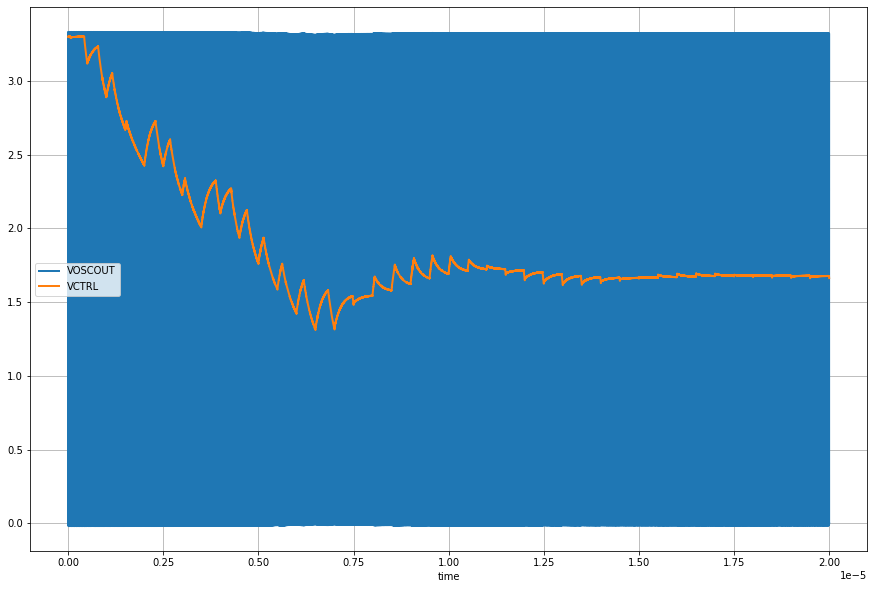

In [42]:

df = pd.read_csv("./PLL_TOP.csv", delim_whitespace=True, header=None)
df.columns = ["time", "VCTRL","time1", "VOSCOUT","time2", "VOSCOUTBY64","time3", "VIN" ,"time4", "VQA","time5", "VQB",]
#df
df.plot(x="time", y=["VOSCOUT","VCTRL"], grid=True, figsize=(15,10), linewidth=2)
plt.show()

The figure above shows the dynamic behaviour of the PLL, when it goes from free running to locked state. The vontrol voltage (VCTRL) varies continuously untill both of the inputs of PFD circuit are aligned in both phase and frequency, resulting in VCO output of 128MHz. The figure below shows the inputs of PFD (VCO/64 and Reference clock). We can see that once the voltage VCTRL settles to a constant value, both of the input signals are aligned.

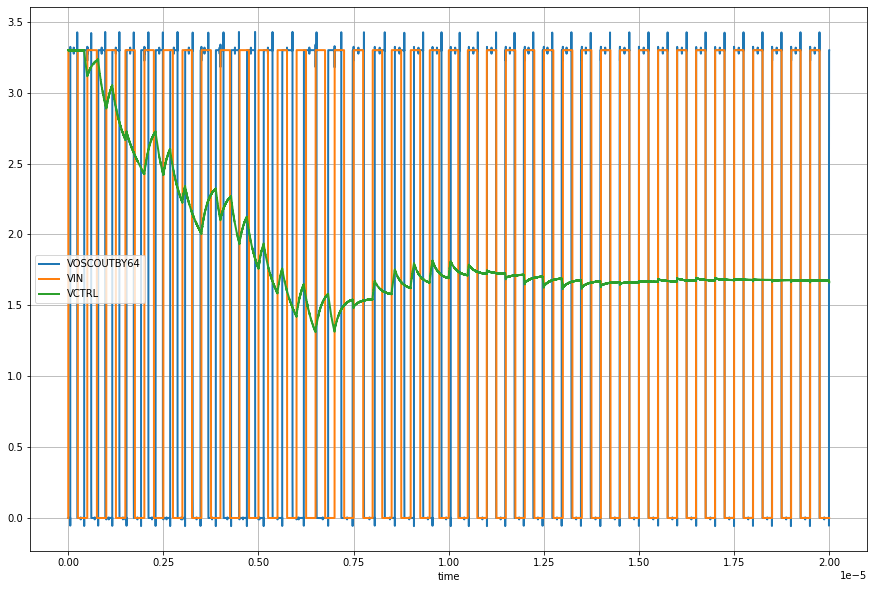

In [43]:
df.plot(x="time", y=["VOSCOUTBY64","VIN","VCTRL"], grid=True, figsize=(15,10), linewidth=2)
plt.show()

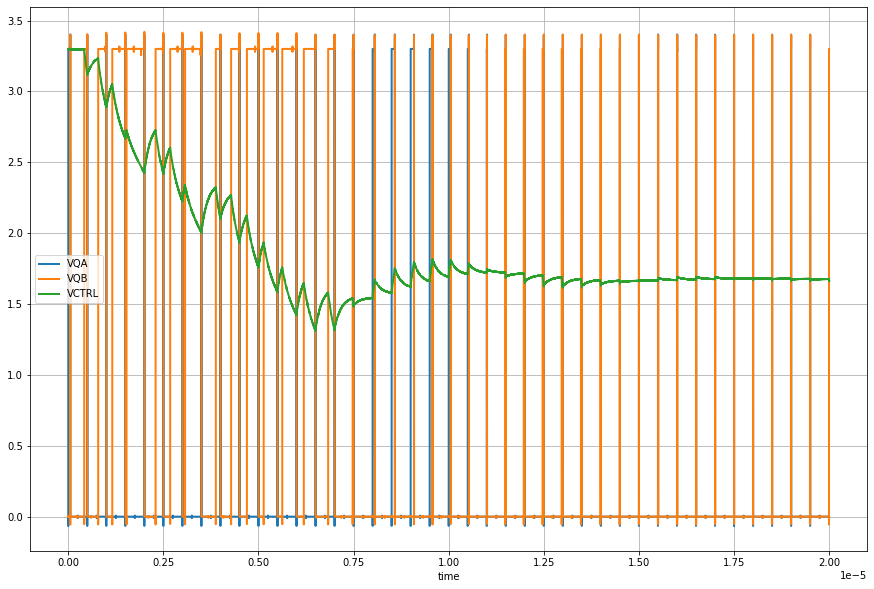

In [44]:
df.plot(x="time", y=["VQA","VQB","VCTRL"], grid=True, figsize=(15,10), linewidth=2)
plt.show()

The functionality of the core clock multiplier circuit is verified. The circuit works at all process corners in the temperature range of 0-75 degrees celsius (commercial temperature range). The next step is to design some supporting circuitry such as bias circuits, and buffers for pads. The biasing currents being used on chip are about 5uA. This is a very small current and difficult to provide from outside chip with such precision. Therefore an internal current bias generator is designed which takes a large current say 100uA, from outside the chip and internally divides that to a 5uA value through current mirroring. Ideally this would have been done using a Band Gap reference circuit on chip, but for testing purpose we can supply this 100uA current from outside the chip.<br/>
<br/>
<br/>
The bias circuit used for making on chip current sources is shown below

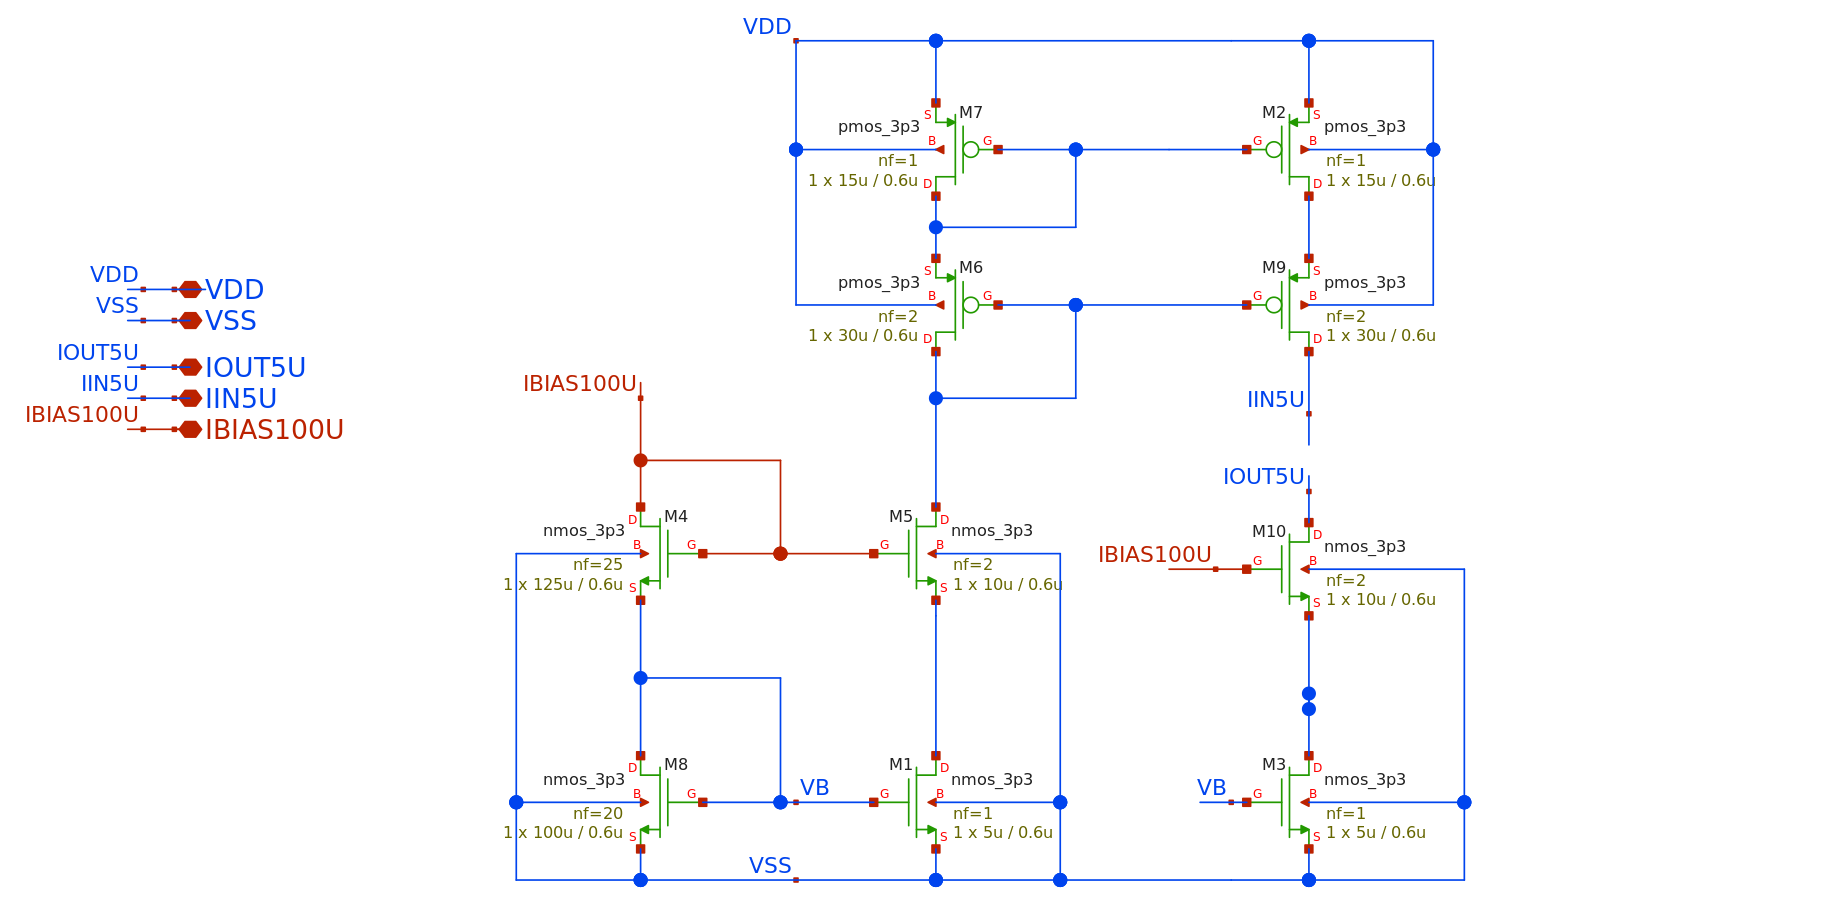

In [45]:
Image('./images/BiasGen.png')

Similarly to test the PLL output, say on a scope, we need to bring the output signal to a digital output pad. This will introduce routing resistance, capacitance along with the pad input capacitance. Simply taking an output from the VCO to the output pad will sverely load the node and the output frequency may decrease below the tuning range. The other problem is that the pad may not have enough bandwidth to output a 128MHz square wave signal with reasonable integrity. So what we do is divide the VCO output by 16/32 times and buffer it to the output pads. 

The complete PLL schematic with biasing and pad drivers is shown below

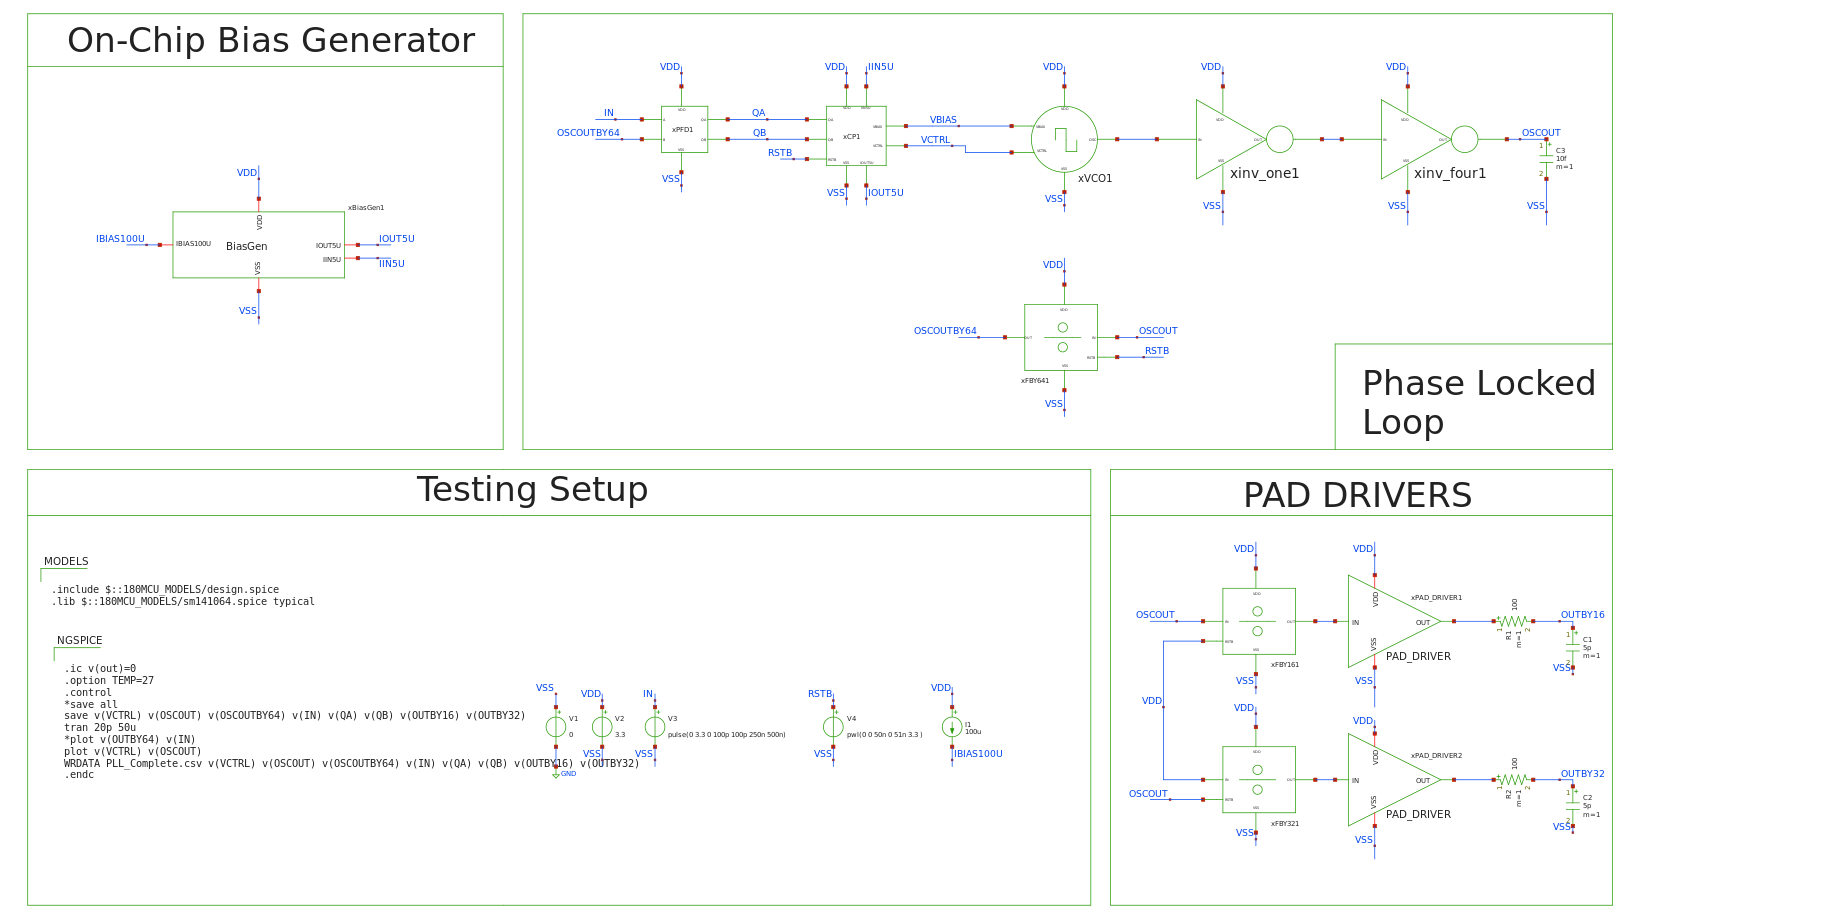

In [46]:
Image('./images/PLL_COMPLETE.png')

# ***Be Advised: Running Following simulation will take upto 1hr !!!***

In [47]:
%%writefile PLL_COMPLETE.spice
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/PLL_COMPLETE.sch
**.subckt PLL_COMPLETE
xPFD1 VDD VSS IN OSCOUTBY64 QA QB PFD
xCP1 VDD IIN5U VBIAS VCTRL IOUT5U VSS RSTB QB QA CP
xVCO1 VDD VSS VBIAS VCTRL net1 VCO
xinv_one1 VDD VSS net1 net2 INV_one
xinv_four1 VDD VSS net2 OSCOUT INV_four
C3 OSCOUT VSS 10f m=1
xFBY641 VDD VSS OSCOUT RSTB OSCOUTBY64 FBY64
V1 VSS GND 0
.save i(v1)
V2 VDD VSS 3.3
.save i(v2)
V3 IN VSS pulse(0 3.3 0 100p 100p 250n 500n)
.save i(v3)
V4 RSTB VSS pwl(0 0 50n 0 51n 3.3 )
.save i(v4)
xBiasGen1 VDD VSS IOUT5U IIN5U IBIAS100U BiasGen
I1 VDD IBIAS100U 100u
xFBY161 VDD VSS OSCOUT VDD net3 FBY16
xFBY321 VDD VSS VDD OSCOUT net4 FBY32
R1 net6 OUTBY16 100 m=1
C1 OUTBY16 VSS 5p m=1
xPAD_DRIVER1 VDD VSS net3 net6 PAD_DRIVER
xPAD_DRIVER2 VDD VSS net4 net5 PAD_DRIVER
R2 net5 OUTBY32 100 m=1
C2 OUTBY32 VSS 5p m=1
**** begin user architecture code

.include ./ngspice/design.spice
.lib ./ngspice/sm141064.spice typical



.ic v(out)=0
.option TEMP=27 wnflag=1
.control
*save all
save v(VCTRL) v(OSCOUT) v(OSCOUTBY64) v(IN) v(QA) v(QB) v(OUTBY16) v(OUTBY32)
tran 20p 20u
*plot v(OUTBY64) v(IN)
*plot v(VCTRL) v(OSCOUT)
WRDATA PLL_COMPLETE.csv v(VCTRL) v(OSCOUT) v(OSCOUTBY64) v(IN) v(QA) v(QB) v(OUTBY16) v(OUTBY32)
.endc


**** end user architecture code
**.ends

* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/PFD.sym # of pins=6
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/PFD.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/PFD.sch
.subckt PFD VDD VSS A B QA QB
*.ipin A
*.iopin VDD
*.iopin VSS
*.opin QA
*.ipin B
*.opin QB
xDFF1 VDD VSS VDD A QA net2 net1 DFF
xDFF2 VDD VSS VDD B QB net3 net1 DFF
xNAND1 VDD VSS QA net1 QB NAND
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/CP.sym # of pins=9
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/CP.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/CP.sch
.subckt CP VDD IIN5U VBIAS VCTRL IOUT5U VSS RSTB QB QA
*.iopin VDD
*.iopin VCTRL
*.ipin RSTB
*.ipin QA
*.ipin QB
*.iopin IIN5U
*.iopin IOUT5U
*.iopin VSS
*.iopin VBIAS
XM1 VBIAS VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM2 VBIAS VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
C2 VBIAS VSS 1p m=1
xinv_one2 VDD VSS QA net2 INV_one
XM3 net3 IOUT5U VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM4 net4 net2 net3 VDD pmos_3p3 L=0.28u W=3u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM5 net4 net1 net5 VSS nmos_3p3 L=0.28u W=1u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM6 net5 IIN5U VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM7 IOUT5U IOUT5U VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM8 IIN5U IIN5U VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
R1 VCTRL net6 100k m=1
C1 net6 VSS 10p m=1
XM9 net7 RSTB VDD VDD pmos_3p3 L=0.6u W=1u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM10 VCTRL RSTB net7 VDD pmos_3p3 L=0.6u W=1u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
xTG1 VDD VSS VDD QB net1 TG
xTG2 VDD VSS RSTB net4 VCTRL TG
C4 VCTRL VSS 2p m=1
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/VCO.sym # of pins=5
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/VCO.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/VCO.sch
.subckt VCO VDD VSS VBIAS VCTRL OSC
*.iopin VDD
*.iopin VSS
*.iopin OSC
*.iopin VBIAS
*.iopin VCTRL
XM5 net7 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM3 net8 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM4 net9 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM8 net10 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM9 net11 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM10 net12 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM11 net13 VBIAS VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM6 net14 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM7 net15 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM12 net16 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM13 net17 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM15 net18 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM16 net19 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM17 net20 VCTRL VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
xinv1 net7 net14 OSC net1 inv
xinv2 net8 net15 net1 net2 inv
xinv3 net9 net16 net2 net3 inv
xinv4 net10 net17 net3 net4 inv
xinv5 net11 net18 net4 net5 inv
xinv6 net12 net19 net5 net6 inv
xinv7 net13 net20 net6 OSC inv
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/INV_one.sym # of pins=4
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/INV_one.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/INV_one.sch
.subckt INV_one VDD VSS IN OUT
*.ipin IN
*.iopin VDD
*.iopin VSS
*.opin OUT
XM1 OUT IN VSS VSS nmos_3p3 L=0.28u W=0.8u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM2 OUT IN VDD VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/INV_four.sym # of pins=4
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/INV_four.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/INV_four.sch
.subckt INV_four VDD VSS IN OUT
*.iopin VDD
*.iopin VSS
*.ipin IN
*.opin OUT
xinv_one1 VDD VSS IN OUT INV_one
xinv_one2 VDD VSS IN OUT INV_one
xinv_one3 VDD VSS IN OUT INV_one
xinv_one4 VDD VSS IN OUT INV_one
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/FBY64.sym # of pins=5
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/FBY64.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/FBY64.sch
.subckt FBY64 VDD VSS IN RSTB OUT
*.ipin IN
*.iopin VDD
*.iopin VSS
*.opin OUT
*.ipin RSTB
xDFF1 VDD VSS net1 IN net2 net1 RSTB DFF
xDFF2 VDD VSS net3 net2 net4 net3 RSTB DFF
xDFF3 VDD VSS net5 net4 net6 net5 RSTB DFF
xDFF4 VDD VSS net7 net6 net8 net7 RSTB DFF
xDFF5 VDD VSS net9 net8 net10 net9 RSTB DFF
xDFF6 VDD VSS net11 net10 OUT net11 RSTB DFF
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/BiasGen.sym # of pins=5
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/BiasGen.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/BiasGen.sch
.subckt BiasGen VDD VSS IOUT5U IIN5U IBIAS100U
*.iopin VDD
*.iopin IIN5U
*.iopin IOUT5U
*.iopin VSS
*.iopin IBIAS100U
XM7 net2 net2 VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM8 VB VB VSS VSS nmos_3p3 L=0.6u W=100u nf=20 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM1 net1 VB VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM2 net5 net2 VDD VDD pmos_3p3 L=0.6u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM3 net3 VB VSS VSS nmos_3p3 L=0.6u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM4 IBIAS100U IBIAS100U VB VSS nmos_3p3 L=0.6u W=125u nf=25 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM5 net4 IBIAS100U net1 VSS nmos_3p3 L=0.6u W=10u nf=2 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM6 net4 net4 net2 VDD pmos_3p3 L=0.6u W=30u nf=2 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM9 IIN5U net4 net5 VDD pmos_3p3 L=0.6u W=30u nf=2 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM10 IOUT5U IBIAS100U net3 VSS nmos_3p3 L=0.6u W=10u nf=2 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/FBY16.sym # of pins=5
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/FBY16.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/FBY16.sch
.subckt FBY16 VDD VSS IN RSTB OUT
*.ipin IN
*.iopin VDD
*.iopin VSS
*.opin OUT
*.ipin RSTB
xDFF1 VDD VSS net1 IN net2 net1 RSTB DFF
xDFF2 VDD VSS net3 net2 net4 net3 RSTB DFF
xDFF3 VDD VSS net5 net4 net6 net5 RSTB DFF
xDFF4 VDD VSS net7 net6 OUT net7 RSTB DFF
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/FBY32.sym # of pins=5
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/FBY32.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/FBY32.sch
.subckt FBY32 VDD VSS IN RSTB OUT
*.ipin IN
*.iopin VDD
*.iopin VSS
*.opin OUT
*.ipin RSTB
xDFF1 VDD VSS net1 IN net2 net1 RSTB DFF
xDFF2 VDD VSS net3 net2 net4 net3 RSTB DFF
xDFF3 VDD VSS net5 net4 net6 net5 RSTB DFF
xDFF4 VDD VSS net7 net6 net8 net7 RSTB DFF
xDFF5 VDD VSS net9 net8 OUT net9 RSTB DFF
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/PAD_DRIVER.sym # of pins=4
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/PAD_DRIVER.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/PAD_DRIVER.sch
.subckt PAD_DRIVER VDD VSS IN OUT
*.iopin VDD
*.opin OUT
*.ipin IN
*.iopin VSS
xinv_four1 VDD VSS IN net1 INV_four
xinv_sixteen1 VDD VSS net1 OUT INV_sixteen
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/DFF.sym # of pins=7
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/DFF.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/DFF.sch
.subckt DFF VDD VSS D CLK Q QB RSTB
*.ipin D
*.iopin VDD
*.iopin VSS
*.opin Q
*.ipin CLK
*.opin QB
*.ipin RSTB
xNAND2 VDD VSS net1 net4 net3 NAND
xNAND_TI1 VDD VSS net4 net3 RSTB CLK NAND_TI
xNAND_TI2 VDD VSS net3 net2 net1 CLK NAND_TI
xNAND_TI3 VDD VSS net2 net1 D RSTB NAND_TI
xNAND3 VDD VSS net3 Q QB NAND
xNAND_TI4 VDD VSS Q QB net2 RSTB NAND_TI
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/NAND.sym # of pins=5
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/NAND.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/NAND.sch
.subckt NAND VDD VSS A OUT B
*.ipin A
*.iopin VDD
*.iopin VSS
*.opin OUT
*.ipin B
XM1 OUT A net1 VSS nmos_3p3 L=0.28u W=1.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM2 OUT A VDD VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM3 net1 B VSS VSS nmos_3p3 L=0.28u W=1.6u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM4 OUT B VDD VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/TG.sym # of pins=5
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/TG.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/TG.sch
.subckt TG VDD VSS CLK A B
*.iopin A
*.iopin VDD
*.iopin VSS
*.iopin B
*.ipin CLK
XM3 A CLKB B VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM4 A CLK B VSS nmos_3p3 L=0.28u W=0.8u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
xinv_one1 VDD VSS CLK CLKB INV_one
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/inv.sym # of pins=4
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/inv.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/inv.sch
.subckt inv VDD VSS IN OUT
*.ipin IN
*.iopin VDD
*.iopin VSS
*.opin OUT
XM1 OUT IN VSS VSS nmos_3p3 L=1u W=5u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
XM2 OUT IN VDD VDD pmos_3p3 L=1u W=15u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=2
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/INV_sixteen.sym # of pins=4
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/INV_sixteen.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/INV_sixteen.sch
.subckt INV_sixteen VDD VSS IN OUT
*.iopin VDD
*.iopin VSS
*.ipin IN
*.opin OUT
xinv_four1 VDD VSS IN OUT INV_four
xinv_four2 VDD VSS IN OUT INV_four
xinv_four3 VDD VSS IN OUT INV_four
xinv_four4 VDD VSS IN OUT INV_four
.ends


* expanding   symbol:  /home/shahidosic/GFProjects/PLL/Xschem/NAND_TI.sym # of pins=6
** sym_path: /home/shahidosic/GFProjects/PLL/Xschem/NAND_TI.sym
** sch_path: /home/shahidosic/GFProjects/PLL/Xschem/NAND_TI.sch
.subckt NAND_TI VDD VSS A OUT C B
*.ipin A
*.iopin VDD
*.iopin VSS
*.opin OUT
*.ipin B
*.ipin C
XM1 OUT A net1 VSS nmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM2 OUT A VDD VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM3 net1 B net2 VSS nmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM4 OUT B VDD VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM5 OUT C VDD VDD pmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
XM6 net2 C VSS VSS nmos_3p3 L=0.28u W=2.4u nf=1 ad='int((nf+1)/2) * W/nf * 0.18u' as='int((nf+2)/2) * W/nf * 0.18u'
+ pd='2*int((nf+1)/2) * (W/nf + 0.18u)' ps='2*int((nf+2)/2) * (W/nf + 0.18u)' nrd='0.18u / W' nrs='0.18u / W'
+ sa=0 sb=0 sd=0 m=1
.ends

.GLOBAL GND
.end


Writing PLL_COMPLETE.spice


In [ ]:
!ngspice -b PLL_COMPLETE.spice

In [ ]:
df = pd.read_csv("./PLL_COMPLETE.csv", delim_whitespace=True, header=None)
df.columns = ["time", "VCTRL","time1", "VOSCOUT","time2", "VOSCOUTBY64","time3", "VIN" ,"time4", "VQA","time5", "VQB","time6", "VOUTBY16","time7", "VOUTBY32"]
#df
df.plot(x="time", y=["VOSCOUT","VCTRL"], grid=True, figsize=(15,10), linewidth=2)
plt.show()

In [ ]:
df.plot(x="time", y=["VOSCOUTBY64","VIN","VCTRL"], grid=True, figsize=(15,10), linewidth=2)
plt.show()

In [ ]:
df.plot(x="time", y=["VOUTBY16","VOUTBY16","VCTRL"], grid=True, figsize=(15,10), linewidth=2)
plt.show()

The design is ready to be moved to layout phase. Layout will be done once the magic and netgen scripts are matured for the GF180MCU by efabless. Once the layout is done and post layout simulations are verified, the design will be submitted in one of the MPW runs.